In [1]:
%load_ext autoreload
%autoreload 2
import datajoint as dj
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from scipy.stats import linregress
dj.config["filepath_checksum_size_limit"] = 1000
import os
os.chdir("/home/sambray/Documents/MS_analysis_samsplaying")
from AnalysisTables.sequence_compression import CompressionIndexParams, CompressionIndexSelection, CompressionIndex
from Analysis.utils import filter_opto_data
from spyglass.decoding.v1.sorted_spikes import SortedSpikesDecodingV1

CompressionIndexParams()
# SortedSpikesDecodingV1()
# (CompressionIndexParams() & {"compression_index_params_name":"slow_graph_distance"}).delete()

[2025-07-30 10:04:35,036][INFO]: Connecting sambray@lmf-db.cin.ucsf.edu:3306
[2025-07-30 10:04:35,076][INFO]: Connected sambray@lmf-db.cin.ucsf.edu:3306
[10:04:41][INFO] Spyglass: Initializing UserEnvironment for spikesorting: sambray_spyglass2025_04


*compression_i filter_speed   min_running_sp pf_bin_size    pf_peak_ratio  delay_range    delay_smoothin min_coincident graph_distance delay_distance smoothing_sigm
+------------+ +------------+ +------------+ +------------+ +------------+ +------------+ +------------+ +------------+ +------------+ +------------+ +------------+
0720slow_graph 10.0           100            5.0            10.0           1500           1000           30             1              2000           250.0         
0720v2_slow_gr 10.0           100            5.0            10.0           1500           300            30             1              2000           10000.0       
0720v3_permiss 10.0           100            5.0            1.0            1500           1000           30             0              2000           500.0         
0720v3_slow    10.0           100            5.0            10.0           1500           1000           30             0              2000           500.0         
0720v3_slow_gr 10.0           100            5.0            10.0           1500           1000           30             1              2000           500.0         
0720v4_permiss 10.0           100            5.0            1.0            1500           1000           30             0              2000           50000.0       
cross_method_g 10.0           100            5.0            1.0            1000           10             30             1              80             nan           
default        10.0           100            5.0            10.0           100            33             30             0              80             nan           
default_graph_ 10.0           100            5.0            10.0           100            33             30             1              80             nan           
fast           10.0           100            5.0            10.0           150            33             30             0              100            nan           
fast_graph_dis 10.0           100            5.0            10.0           150            33             30             1              100            nan           
permissive_def 10.0           100            5.0            1.0            100            33             30             0              80             nan           
   ...
 (Total: 15)

In [3]:
exclude_simultaneous = False
track = "early_wtrack"
# track = "lineartrack"
dlc_pos = track != "lineartrack"

results = {}


from Style.style_guide import animal_style

animal_list = animal_style.index.values
animal_list = [
    x
    for x in animal_list
    if x not in ["control", "transfected", "Banner", "Odins", "Dan"]
]
animal_list.extend(["control", "transfected"])

# animal_list = ["Yoshi", "Winnie"]
# animal_list = ["transfected", "control"]

In [5]:
# results.pop("control")
# results.pop("transfected")

In [6]:
min_spikes_fast = 1
min_spikes_slow = 1

# results = {}

for animal in animal_list:
    if animal in results:
        continue
    dataset_key = {
        "animal": animal,
        "targeted_phase": 90,
        "track_type": track,
        "min_pulse_length": 20,
        "laser_power": 77,
    }
    dataset = filter_opto_data(dataset_key)
    # if animal in ["control", "transfected"]:
    #     for exclude_animal in ["Olive", "Frodo", "Bilbo"]:
    #         dataset = dataset - f"nwb_file_name LIKE '{exclude_animal}%'"

    query = CompressionIndex() & dataset.proj(decoding_interval="interval_list_name")
    slow_query = query & "compression_index_params_name LIKE '0720v3_slow%'"
    fast_query = query & "compression_index_params_name LIKE 'default%'"
    # query =
    # query = query & "encoding_interval LIKE '%valid times'"
    control_slow_query = slow_query & "encoding_interval LIKE '%control_interval'"
    test_slow_query = slow_query & "encoding_interval LIKE '%test_interval'"
    control_fast_query = fast_query & "encoding_interval LIKE '%control_interval'"
    test_fast_query = fast_query & "encoding_interval LIKE '%test_interval'"

    control_slow_df = control_slow_query.fetch_delays_dataframes()
    test_slow_df = test_slow_query.fetch_delays_dataframes()
    control_fast_df = control_fast_query.fetch_delays_dataframes()
    test_fast_df = test_fast_query.fetch_delays_dataframes()

    control_slow_df = control_slow_df[control_slow_df.n_coincidients >= min_spikes_slow]
    test_slow_df = test_slow_df[test_slow_df.n_coincidients >= min_spikes_slow]
    control_fast_df = control_fast_df[control_fast_df.n_coincidients >= min_spikes_fast]
    test_fast_df = test_fast_df[test_fast_df.n_coincidients >= min_spikes_fast]

    merged_control_df = pd.merge(
        control_slow_df,
        control_fast_df,
        on=["s_id_1", "s_id_2"],
        suffixes=("_slow", "_fast"),
    )
    merged_test_df = pd.merge(
        test_slow_df,
        test_fast_df,
        on=["s_id_1", "s_id_2"],
        suffixes=("_slow", "_fast"),
    )
    results_i = {
        "control": merged_control_df,
        "test": merged_test_df,
    }

    results[animal] = results_i

datasets: 9


[2025-07-30 10:37:34,006][WARNING]: Skipped checksum for file with hash: 21735ab2-98fd-0ff4-4dab-34af01016554, and path: /stelmo/nwb/analysis/Winnie20220719/Winnie20220719_MOY0N67BJY.nwb
[2025-07-30 10:37:34,016][WARNING]: Skipped checksum for file with hash: 21735ab2-98fd-0ff4-4dab-34af01016554, and path: /stelmo/nwb/analysis/Winnie20220719/Winnie20220719_MOY0N67BJY.nwb
[2025-07-30 10:37:34,027][WARNING]: Skipped checksum for file with hash: dc557a82-7548-ddf8-39a9-c06f1961177a, and path: /stelmo/nwb/analysis/Winnie20220719/Winnie20220719_YE45A6XOVN.nwb
[2025-07-30 10:37:34,034][WARNING]: Skipped checksum for file with hash: dc557a82-7548-ddf8-39a9-c06f1961177a, and path: /stelmo/nwb/analysis/Winnie20220719/Winnie20220719_YE45A6XOVN.nwb
[2025-07-30 10:37:34,042][WARNING]: Skipped checksum for file with hash: 02f57d9b-b335-cc02-4939-6c4b83065e58, and path: /stelmo/nwb/analysis/Winnie20220719/Winnie20220719_VJWSW289PO.nwb
[2025-07-30 10:37:34,049][WARNING]: Skipped checksum for file wit

datasets: 9


[2025-07-30 10:41:02,976][WARNING]: Skipped checksum for file with hash: dea7a58d-6c17-382f-def2-a0d89ef2a48d, and path: /stelmo/nwb/analysis/Frodo20230814/Frodo20230814_V3NSB08D4S.nwb
[2025-07-30 10:41:02,985][WARNING]: Skipped checksum for file with hash: dea7a58d-6c17-382f-def2-a0d89ef2a48d, and path: /stelmo/nwb/analysis/Frodo20230814/Frodo20230814_V3NSB08D4S.nwb
[2025-07-30 10:41:02,994][WARNING]: Skipped checksum for file with hash: 29ea3a50-0ce1-1f5d-65e9-b24f346d56d9, and path: /stelmo/nwb/analysis/Frodo20230814/Frodo20230814_K93D4CMCFD.nwb
[2025-07-30 10:41:03,002][WARNING]: Skipped checksum for file with hash: 29ea3a50-0ce1-1f5d-65e9-b24f346d56d9, and path: /stelmo/nwb/analysis/Frodo20230814/Frodo20230814_K93D4CMCFD.nwb
[2025-07-30 10:41:03,012][WARNING]: Skipped checksum for file with hash: db9e635f-5b1c-314c-5ffb-103a60b344ca, and path: /stelmo/nwb/analysis/Frodo20230814/Frodo20230814_ARDYUH6TM5.nwb
[2025-07-30 10:41:03,019][WARNING]: Skipped checksum for file with hash: db

datasets: 10


[2025-07-30 10:47:51,349][WARNING]: Skipped checksum for file with hash: d57bbf3f-86ed-e03a-573b-185ce9d5a9f8, and path: /stelmo/nwb/analysis/Totoro20220614/Totoro20220614_531WH4B2U6.nwb
[2025-07-30 10:47:51,359][WARNING]: Skipped checksum for file with hash: d57bbf3f-86ed-e03a-573b-185ce9d5a9f8, and path: /stelmo/nwb/analysis/Totoro20220614/Totoro20220614_531WH4B2U6.nwb
[2025-07-30 10:47:51,371][WARNING]: Skipped checksum for file with hash: 06d16403-5910-76de-f990-11c2697fa534, and path: /stelmo/nwb/analysis/Totoro20220614/Totoro20220614_NQ4DQC87TE.nwb
[2025-07-30 10:47:51,381][WARNING]: Skipped checksum for file with hash: 06d16403-5910-76de-f990-11c2697fa534, and path: /stelmo/nwb/analysis/Totoro20220614/Totoro20220614_NQ4DQC87TE.nwb
[2025-07-30 10:47:51,392][WARNING]: Skipped checksum for file with hash: 8885188d-dff9-5f34-1bee-6d1d512e3c35, and path: /stelmo/nwb/analysis/Totoro20220614/Totoro20220614_ZC164RC4PE.nwb
[2025-07-30 10:47:51,402][WARNING]: Skipped checksum for file wit

datasets: 10


[2025-07-30 10:51:20,211][WARNING]: Skipped checksum for file with hash: 85e23d25-f917-1f97-9e63-6db231ba7cb4, and path: /stelmo/nwb/analysis/Wallie20220922/Wallie20220922_586SOU67DQ.nwb
[2025-07-30 10:51:20,219][WARNING]: Skipped checksum for file with hash: 85e23d25-f917-1f97-9e63-6db231ba7cb4, and path: /stelmo/nwb/analysis/Wallie20220922/Wallie20220922_586SOU67DQ.nwb
[2025-07-30 10:51:20,232][WARNING]: Skipped checksum for file with hash: 5a5a3483-3cf3-3f4b-c0d7-ba8dba4d489a, and path: /stelmo/nwb/analysis/Wallie20220922/Wallie20220922_FKV7IZUPZS.nwb
[2025-07-30 10:51:20,239][WARNING]: Skipped checksum for file with hash: 5a5a3483-3cf3-3f4b-c0d7-ba8dba4d489a, and path: /stelmo/nwb/analysis/Wallie20220922/Wallie20220922_FKV7IZUPZS.nwb
[2025-07-30 10:51:20,248][WARNING]: Skipped checksum for file with hash: dbd06879-22c4-3b46-fa1e-41ba783f709c, and path: /stelmo/nwb/analysis/Wallie20220922/Wallie20220922_7M8WZ85H4Z.nwb
[2025-07-30 10:51:20,256][WARNING]: Skipped checksum for file wit

datasets: 8


[2025-07-30 10:54:48,059][WARNING]: Skipped checksum for file with hash: ad060950-7da8-9193-a2f3-4b4caeb45b08, and path: /stelmo/nwb/analysis/Olive20220711/Olive20220711_E0GJTD2ECF.nwb
[2025-07-30 10:54:48,066][WARNING]: Skipped checksum for file with hash: ad060950-7da8-9193-a2f3-4b4caeb45b08, and path: /stelmo/nwb/analysis/Olive20220711/Olive20220711_E0GJTD2ECF.nwb
[2025-07-30 10:54:48,073][WARNING]: Skipped checksum for file with hash: 798bc639-75f4-63ee-a396-7aab7fb0f438, and path: /stelmo/nwb/analysis/Olive20220711/Olive20220711_YF53DRRE0K.nwb
[2025-07-30 10:54:48,079][WARNING]: Skipped checksum for file with hash: 798bc639-75f4-63ee-a396-7aab7fb0f438, and path: /stelmo/nwb/analysis/Olive20220711/Olive20220711_YF53DRRE0K.nwb
[2025-07-30 10:54:48,086][WARNING]: Skipped checksum for file with hash: 977e12cc-feaa-31ae-57ff-d84cdd560170, and path: /stelmo/nwb/analysis/Olive20220711/Olive20220711_DH49R1HSFD.nwb
[2025-07-30 10:54:48,093][WARNING]: Skipped checksum for file with hash: 97

datasets: 16


[2025-07-30 10:58:22,672][WARNING]: Skipped checksum for file with hash: afa6e4d6-6cb1-6d57-6465-c56618885547, and path: /stelmo/nwb/analysis/Yoshi20220517/Yoshi20220517_7ZNAKWGT80.nwb
[2025-07-30 10:58:22,680][WARNING]: Skipped checksum for file with hash: afa6e4d6-6cb1-6d57-6465-c56618885547, and path: /stelmo/nwb/analysis/Yoshi20220517/Yoshi20220517_7ZNAKWGT80.nwb
[2025-07-30 10:58:22,687][WARNING]: Skipped checksum for file with hash: 8b0436a9-bc4f-be79-644a-c212d52f97e8, and path: /stelmo/nwb/analysis/Yoshi20220517/Yoshi20220517_AMRO1V0GVS.nwb
[2025-07-30 10:58:22,694][WARNING]: Skipped checksum for file with hash: 8b0436a9-bc4f-be79-644a-c212d52f97e8, and path: /stelmo/nwb/analysis/Yoshi20220517/Yoshi20220517_AMRO1V0GVS.nwb
[2025-07-30 10:58:22,704][WARNING]: Skipped checksum for file with hash: a71e7ccc-9591-4349-c190-769ab79bcd13, and path: /stelmo/nwb/analysis/Yoshi20220517/Yoshi20220517_RYC5DK2PW6.nwb
[2025-07-30 10:58:22,715][WARNING]: Skipped checksum for file with hash: a7

datasets: 8


[2025-07-30 11:04:43,900][WARNING]: Skipped checksum for file with hash: c72a769b-5e73-47a9-5158-cdb4405b00ec, and path: /stelmo/nwb/analysis/Bilbo20230802/Bilbo20230802_3W3JBDU5F8.nwb
[2025-07-30 11:04:43,907][WARNING]: Skipped checksum for file with hash: c72a769b-5e73-47a9-5158-cdb4405b00ec, and path: /stelmo/nwb/analysis/Bilbo20230802/Bilbo20230802_3W3JBDU5F8.nwb
[2025-07-30 11:04:43,916][WARNING]: Skipped checksum for file with hash: 6675d334-976e-6a7f-71a3-ff712c6b3412, and path: /stelmo/nwb/analysis/Bilbo20230802/Bilbo20230802_24VC8QJMBD.nwb
[2025-07-30 11:04:43,923][WARNING]: Skipped checksum for file with hash: 6675d334-976e-6a7f-71a3-ff712c6b3412, and path: /stelmo/nwb/analysis/Bilbo20230802/Bilbo20230802_24VC8QJMBD.nwb
[2025-07-30 11:04:43,932][WARNING]: Skipped checksum for file with hash: f91e3d4f-fd7e-b6a1-4a4a-88bd959cfdfe, and path: /stelmo/nwb/analysis/Bilbo20230802/Bilbo20230802_1O1L5FKXQD.nwb
[2025-07-30 11:04:43,939][WARNING]: Skipped checksum for file with hash: f9

datasets: 42


[2025-07-30 11:11:18,740][WARNING]: Skipped checksum for file with hash: c72a769b-5e73-47a9-5158-cdb4405b00ec, and path: /stelmo/nwb/analysis/Bilbo20230802/Bilbo20230802_3W3JBDU5F8.nwb
[2025-07-30 11:11:18,749][WARNING]: Skipped checksum for file with hash: c72a769b-5e73-47a9-5158-cdb4405b00ec, and path: /stelmo/nwb/analysis/Bilbo20230802/Bilbo20230802_3W3JBDU5F8.nwb
[2025-07-30 11:11:18,757][WARNING]: Skipped checksum for file with hash: 6675d334-976e-6a7f-71a3-ff712c6b3412, and path: /stelmo/nwb/analysis/Bilbo20230802/Bilbo20230802_24VC8QJMBD.nwb
[2025-07-30 11:11:18,765][WARNING]: Skipped checksum for file with hash: 6675d334-976e-6a7f-71a3-ff712c6b3412, and path: /stelmo/nwb/analysis/Bilbo20230802/Bilbo20230802_24VC8QJMBD.nwb
[2025-07-30 11:11:18,774][WARNING]: Skipped checksum for file with hash: f91e3d4f-fd7e-b6a1-4a4a-88bd959cfdfe, and path: /stelmo/nwb/analysis/Bilbo20230802/Bilbo20230802_1O1L5FKXQD.nwb
[2025-07-30 11:11:18,782][WARNING]: Skipped checksum for file with hash: f9

datasets: 44


[2025-07-30 11:13:50,673][WARNING]: Skipped checksum for file with hash: dea7a58d-6c17-382f-def2-a0d89ef2a48d, and path: /stelmo/nwb/analysis/Frodo20230814/Frodo20230814_V3NSB08D4S.nwb
[2025-07-30 11:13:50,685][WARNING]: Skipped checksum for file with hash: dea7a58d-6c17-382f-def2-a0d89ef2a48d, and path: /stelmo/nwb/analysis/Frodo20230814/Frodo20230814_V3NSB08D4S.nwb
[2025-07-30 11:13:50,695][WARNING]: Skipped checksum for file with hash: 29ea3a50-0ce1-1f5d-65e9-b24f346d56d9, and path: /stelmo/nwb/analysis/Frodo20230814/Frodo20230814_K93D4CMCFD.nwb
[2025-07-30 11:13:50,706][WARNING]: Skipped checksum for file with hash: 29ea3a50-0ce1-1f5d-65e9-b24f346d56d9, and path: /stelmo/nwb/analysis/Frodo20230814/Frodo20230814_K93D4CMCFD.nwb
[2025-07-30 11:13:50,716][WARNING]: Skipped checksum for file with hash: db9e635f-5b1c-314c-5ffb-103a60b344ca, and path: /stelmo/nwb/analysis/Frodo20230814/Frodo20230814_ARDYUH6TM5.nwb
[2025-07-30 11:13:50,728][WARNING]: Skipped checksum for file with hash: db

In [478]:
dataset

[2025-07-23 09:40:37,708][WARNING]: MySQL server has gone away. Reconnecting to the server.


*nwb_file_name *interval_list *dio_event_nam *opto_infer_pa optogenetic_pr pulse_length_m inter_pulse_in inter_train_in period_ms     pulses_per_tra number_trains  stim_on     test_inter control_in laser_power    targeted_phase
+------------+ +------------+ +------------+ +------------+ +------------+ +------------+ +------------+ +------------+ +-----------+ +------------+ +------------+ +---------+ +--------+ +--------+ +------------+ +------------+
Bilbo20230802_ pos 1 valid ti stim           default_phase_ phase_targetin 40             82             -1             -1            -1             -1.0           1           =BLOB=     =BLOB=     77.0           90            
Bilbo20230802_ pos 11 valid t stim           default_phase_ phase_targetin 40             71             -1             -1            -1             -1.0           1           =BLOB=     =BLOB=     77.0           90            
Bilbo20230802_ pos 13 valid t stim           default_phase_ phase_targetin 40             69             -1             -1            -1             -1.0           1           =BLOB=     =BLOB=     77.0           90            
Bilbo20230802_ pos 15 valid t stim           default_phase_ phase_targetin 40             70             -1             -1            -1             -1.0           1           =BLOB=     =BLOB=     77.0           90            
Bilbo20230802_ pos 3 valid ti stim           default_phase_ phase_targetin 40             82             -1             -1            -1             -1.0           1           =BLOB=     =BLOB=     77.0           90            
Bilbo20230802_ pos 5 valid ti stim           default_phase_ phase_targetin 40             86             -1             -1            -1             -1.0           1           =BLOB=     =BLOB=     77.0           90            
Bilbo20230802_ pos 7 valid ti stim           default_phase_ phase_targetin 39             81             -1             -1            -1             -1.0           1           =BLOB=     =BLOB=     77.0           90            
Bilbo20230802_ pos 9 valid ti stim           default_phase_ phase_targetin 40             71             -1             -1            -1             -1.0           1           =BLOB=     =BLOB=     77.0           90            
Olive20220711_ pos 1 valid ti stim           default_phase_ phase_targetin 40             82             -1             -1            -1             -1.0           1           =BLOB=     =BLOB=     77.0           90            
Olive20220711_ pos 11 valid t stim           default_phase_ phase_targetin 39             52             -1             -1            -1             -1.0           1           =BLOB=     =BLOB=     77.0           90            
Olive20220711_ pos 13 valid t stim           default_phase_ phase_targetin 39             69             -1             -1            -1             -1.0           1           =BLOB=     =BLOB=     77.0           90            
Olive20220711_ pos 15 valid t stim           default_phase_ phase_targetin 40             71             -1             -1            -1             -1.0           1           =BLOB=     =BLOB=     77.0           90            
   ...
 (Total: 42)

## Bootstrapped heatmap spectrums

In [4]:
from Analysis.lfp_analysis import power_spectrum

slow_bin_size = 8
fast_bin_size = 3
n_boot = 1000


def get_power_spectrum_from_pairs(slow_val, fast_val, bx, by):
    # standardize order
    ind = np.where(slow_val < 0)[0]
    slow_val[ind] = -slow_val[ind]
    fast_val[ind] = -fast_val[ind]
    # get heatmap
    H, bx, by = np.histogram2d(slow_val, fast_val, bins=(bx, by))
    H = H + 1  # laplace shift
    H = H / H.sum(axis=1)[:, None]

    p_all = []
    for xx in H.T:
        f, p, _ = power_spectrum(xx, xx.size, 1000 / np.mean(np.diff(bx)))
        p_all.append(p)

    return f, np.mean(p_all, axis=0)


spectrum_results = {animal: {} for animal in results}

for a, animal in zip(ax, results.keys()):
    # animal = "control"
    merged_control_df = results[animal]["control"]
    merged_test_df = results[animal]["test"]

    lim_x = 501

    bx = np.arange(0, lim_x, slow_bin_size)
    by = np.arange(-80, 80, fast_bin_size)

    for a_i, merged_df, cond in zip(
        a, [merged_control_df, merged_test_df], ["stim off", "stim on"]
    ):
        slow_val = merged_df.peak_delay_slow.values.copy()
        fast_val = merged_df.peak_delay_fast.values.copy()
        spectrums = []
        for _ in range(n_boot):
            ind_sample = np.random.choice(len(slow_val), len(slow_val), replace=True)
            f, p = get_power_spectrum_from_pairs(
                slow_val[ind_sample], fast_val[ind_sample], bx, by
            )
            spectrums.append(p)
        spectrums = np.array(spectrums)
        spectrum_results[animal][cond] = spectrums

NameError: name 'ax' is not defined

In [8]:
cond = "stim on"
plot_list = [
    "Winnie",
    # # "Frodo",
    # "Totoro",
    # # "Olive",
    # # "Bilbo",
    # "Wallie",
    "Yoshi",
    #
    # "control",
    # "transfected",
]
log = True


fig = plt.figure(figsize=(10, 5))
for animal in plot_list:
    spectrums = spectrum_results[animal][cond]
    color = animal_style.loc[animal, "color"]

    plt.plot(f, np.median(spectrums, axis=0), color=color, label=animal)
    plt.fill_between(
        f,
        np.percentile(spectrums, 2.5, axis=0),
        np.percentile(spectrums, 97.5, axis=0),
        alpha=0.3,
        facecolor=color,
    )

plt.legend()
plt.xlim(0, 20)
plt.xlabel("Frequency across slow delays (Hz)")
plt.ylabel("Power spectrum (a.u.) of fast delay probability")
from Analysis.utils import violin_scatter


def spectrum_score(f, p):

    ind_pos = np.logical_and(f > 8, f < 12)
    ind_neg = np.logical_or(
        np.logical_and(f > 12, f < 15), np.logical_and(f > 4, f < 8)
    )
    pos_power = p[ind_pos].mean()
    neg_power = p[ind_neg].mean()
    if log:
        return np.log10(pos_power / neg_power)
    return pos_power / neg_power


cond = "stim on"


fig2 = plt.figure(figsize=(10, 5))
all_scores = {}
for i, animal in enumerate(plot_list):
    spectrums = spectrum_results[animal][cond]
    scores = [spectrum_score(f, p) for p in spectrums]
    all_scores[animal] = scores
    violin_scatter(scores, pos=[i], color=animal_style.loc[animal, "color"])

plt.xticks(np.arange(len(plot_list)), plot_list)
if log:
    plt.ylabel("Log 10 ratio of power in 8-12 Hz to avg in (4-8 Hz and 12-15 Hz)")
else:
    plt.ylabel("Ratio of power in 8-12 Hz to avg in (4-8 Hz and 12-15 Hz)")

tag = "_grouped_animals"
# tag = "_individual_animals"
plt.rcParams["svg.fonttype"] = "none"
# fig.savefig(f"wtrack_peak_delays_spectrograms{tag}.svg")
# fig2.savefig(f"wtrack_peak_delays_scores{tag}.svg")

# from scipy.stats import ttest_ind
# ttest_ind(all_scores['control'],all_scores['transfected'], equal_var=False).pvalue

KeyError: 'stim on'

<Figure size 1000x500 with 0 Axes>

In [278]:
from statsmodels.formula.api import mixedlm

model_df = []

for i, (animal, data) in enumerate(all_scores.items()):
    for d in data:
        model_df.append(
            {
                "Animal": i,
                "Treatment": (
                    "transfected"
                    if animal_style.loc[animal, "background"] == "indianred"
                    else "control"
                ),
                "Score": d,
            }
        )

model_df = pd.DataFrame(model_df)
model_df
# Convert the 'Treatment' column to a categorical variable
model_df["Treatment"] = model_df["Treatment"].astype("category")
# model_df["Interval"] = model_df["Interval"].astype("category")
# model_df['Animal'] = model_df['Treatment'].astype('category')

# Fit the mixed-effects model
model = mixedlm("Score ~ Treatment", model_df, groups=model_df["Animal"])
result = model.fit()

# Print the summary of the model
print(result.summary())
result.pvalues

               Mixed Linear Model Regression Results
Model:                MixedLM     Dependent Variable:     Score    
No. Observations:     4000        Method:                 REML     
No. Groups:           4           Scale:                  0.0016   
Min. group size:      1000        Log-Likelihood:         7143.4883
Max. group size:      1000        Converged:              Yes      
Mean group size:      1000.0                                       
-------------------------------------------------------------------
                         Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------------
Intercept                 0.431    0.103  4.187 0.000  0.229  0.632
Treatment[T.transfected] -0.400    0.145 -2.748 0.006 -0.685 -0.115
Group Var                 0.021    0.496                           



Intercept                   0.000028
Treatment[T.transfected]    0.005999
Group Var                   0.290266
dtype: float64

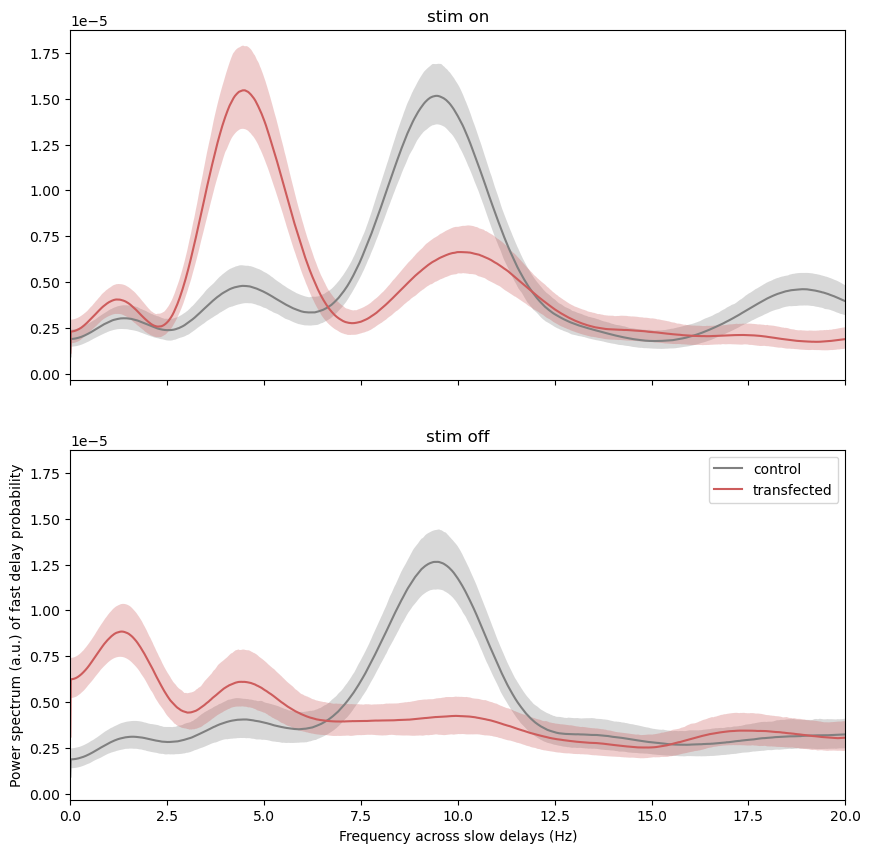

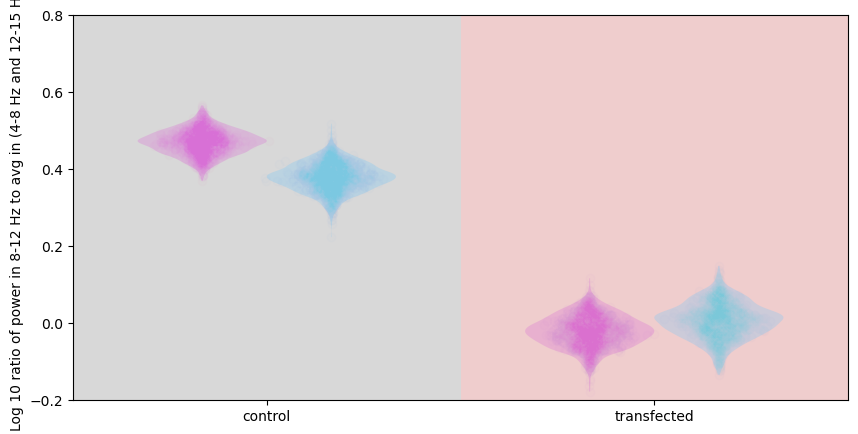

In [ ]:
from Style.style_guide import interval_style

plot_list = [
    # "Winnie",
    # # "Frodo",
    # "Totoro",
    # # "Olive",
    # # "Bilbo",
    # "Wallie",
    # "Yoshi",
    "control",
    "transfected",
]
log = True


fig, ax = plt.subplots(nrows=2, figsize=(10, 10), sharex=True, sharey=True)
for animal in plot_list:
    for i, cond in enumerate(["stim on", "stim off"]):
        # i=0
        spectrums = spectrum_results[animal][cond]
        color = animal_style.loc[animal, "color"]
        back_color = (
            interval_style["control"] if cond == "stim off" else interval_style["test"]
        )

        ax[i].plot(
            f,
            np.median(spectrums, axis=0),
            color=color,
            label=animal,
            #    ls = "-." if cond=="stim on" else "-"
        )
        ax[i].fill_between(
            f,
            np.percentile(spectrums, 2.5, axis=0),
            np.percentile(spectrums, 97.5, axis=0),
            alpha=0.3,
            facecolor=color,
        )
        ax[i].set_title(cond)
        # ax[i].patch.set_facecolor(back_color, alpha=.1)

plt.legend()
plt.xlim(0, 20)
plt.xlabel("Frequency across slow delays (Hz)")
plt.ylabel("Power spectrum (a.u.) of fast delay probability")
from Analysis.utils import violin_scatter


def spectrum_score(f, p):

    ind_pos = np.logical_and(f > 8, f < 12)
    ind_neg = np.logical_or(
        np.logical_and(f > 12, f < 15), np.logical_and(f > 4, f < 8)
    )
    pos_power = p[ind_pos].mean()
    neg_power = p[ind_neg].mean()
    if log:
        return np.log10(pos_power / neg_power)
    return pos_power / neg_power


fig2 = plt.figure(figsize=(10, 5))
all_scores = {}
for i, animal in enumerate(plot_list):
    for j, cond in enumerate(["stim on", "stim off"]):

        spectrums = spectrum_results[animal][cond]
        back_color = animal_style.loc[animal, "color"]
        color = (
            interval_style["control"] if cond == "stim off" else interval_style["test"]
        )
        scores = [spectrum_score(f, p) for p in spectrums]
        all_scores[animal] = scores
        violin_scatter(scores, pos=[1.5 * i + 0.5 * j], color=color)
    plt.fill_between(
        [
            1.5 * i - 0.5,
            1.5 * (i + 1) - 0.5,
        ],
        -0.2,
        0.8,
        facecolor=back_color,
        alpha=0.3,
        zorder=-1,
    )
plt.xlim(-0.5, (len(plot_list)) * 1.5 - 0.5)
plt.ylim(-0.2, 0.8)
plt.xticks(1.5 * np.arange(len(plot_list)) + 0.25, plot_list)
if log:
    plt.ylabel("Log 10 ratio of power in 8-12 Hz to avg in (4-8 Hz and 12-15 Hz)")
else:
    plt.ylabel("Ratio of power in 8-12 Hz to avg in (4-8 Hz and 12-15 Hz)")

tag = "_grouped_animals"
tag = "_individual_animals"
plt.rcParams["svg.fonttype"] = "none"

## Bootstrapped heatmap ridge

In [224]:
from Analysis.lfp_analysis import power_spectrum

slow_bin_size = 2
fast_bin_size = 3
n_boot = 300


def get_ridge_spectrum_from_pairs(slow_val, fast_val, bx, by):
    # standardize order
    ind = np.where(slow_val < 0)[0]
    slow_val[ind] = -slow_val[ind]
    fast_val[ind] = -fast_val[ind]
    # get heatmap
    H, bx, by = np.histogram2d(slow_val, fast_val, bins=(bx, by))
    H = H + 1  # laplace shift
    H = H / H.sum(axis=1)[:, None]

    ridge = by[np.argmax(H, axis=1)]

    f, p, _ = power_spectrum(ridge, ridge.size, 1000 / np.mean(np.diff(bx)))

    return ridge, f, p


spectrum_results = {animal: {} for animal in results}
ridge_results = {animal: {} for animal in results}

for animal in results.keys():
    # animal = "control"
    merged_control_df = results[animal]["control"]
    merged_test_df = results[animal]["test"]

    lim_x = 1001

    bx = np.arange(0, lim_x, slow_bin_size)
    by = np.arange(-80, 80, fast_bin_size)

    for merged_df, cond in zip(
        [merged_control_df, merged_test_df], ["stim off", "stim on"]
    ):
        slow_val = merged_df.peak_delay_slow.values.copy()
        fast_val = merged_df.peak_delay_fast.values.copy()
        ridges = []
        spectrums = []
        for _ in range(n_boot):
            ind_sample = np.random.choice(len(slow_val), len(slow_val), replace=True)
            r, f, p = get_ridge_spectrum_from_pairs(
                slow_val[ind_sample], fast_val[ind_sample], bx, by
            )
            spectrums.append(p)
            ridges.append(r)
        spectrums = np.array(spectrums)
        ridges = np.array(ridges)
        ridge_results[animal][cond] = ridges
        spectrum_results[animal][cond] = spectrums

Text(0.5, 0, 'frequency in long timescale (Hz)')

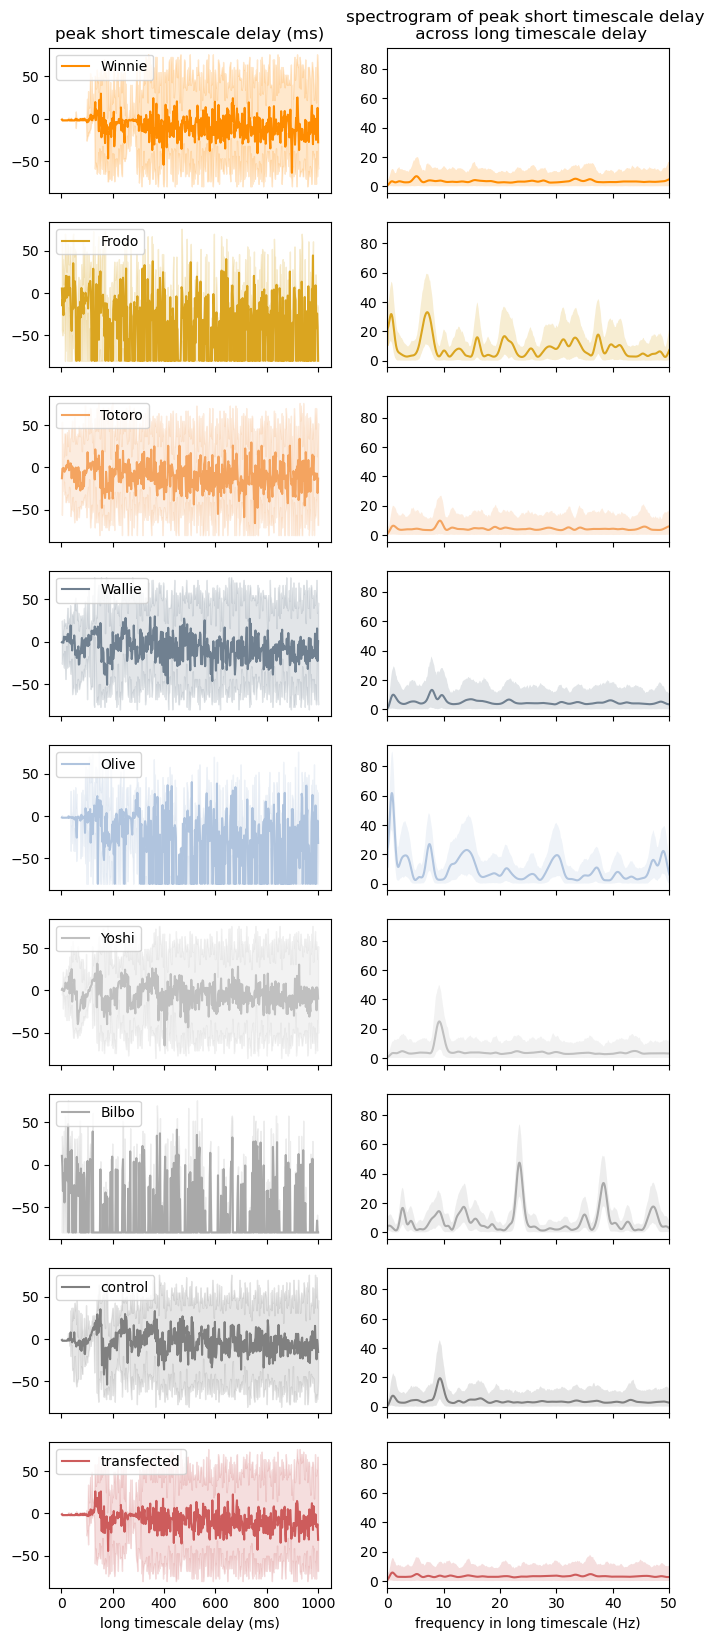

In [226]:
cond = "stim on"
fig, ax_all = plt.subplots(
    nrows=len(ridge_results), ncols=2, sharex="col", sharey="col", figsize=(8, 20)
)
ax = ax_all[:, 0]
for i, (animal, r) in enumerate(ridge_results.items()):
    ridges = r[cond]
    ax[i].plot(
        bx[1:],
        np.mean(ridges, axis=0),
        color=animal_style.loc[animal, "color"],
        label=animal,
    )
    ax[i].fill_between(
        bx[1:],
        np.percentile(ridges, 0.5, axis=0),
        np.percentile(ridges, 99.5, axis=0),
        color=animal_style.loc[animal, "color"],
        alpha=0.2,
    )
    ax[i].legend(loc="upper left")

# ax[0].set_xlim(0, 400)
ax[0].set_title("peak short timescale delay (ms)")
ax[-1].set_xlabel("long timescale delay (ms)")


# fig2, ax2 = plt.subplots(
#     nrows=len(ridge_results), sharex=True, sharey=True, figsize=(8, 20)
# )
ax2 = ax_all[:, 1]
for i, (animal, spec) in enumerate(spectrum_results.items()):
    spectrums = spec[cond]
    ax2[i].plot(
        f,
        np.mean(spectrums, axis=0),
        color=animal_style.loc[animal, "color"],
        label=animal,
    )
    ax2[i].fill_between(
        f,
        np.percentile(spectrums, 2.5, axis=0),
        np.percentile(spectrums, 97.5, axis=0),
        facecolor=animal_style.loc[animal, "color"],
        alpha=0.2,
    )

# ax2[0].set_ylim(0,15)
ax2[0].set_xlim(0, 50)
ax2[0].set_title(
    "spectrogram of peak short timescale delay \n across long timescale delay"
)
ax2[-1].set_xlabel("frequency in long timescale (Hz)")

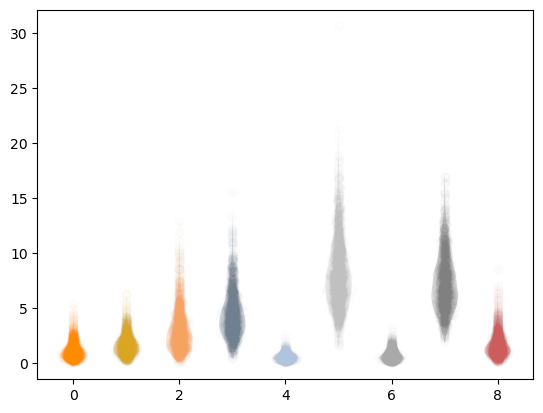

In [ ]:
fig = plt.figure()
ax = fig.gca()


def peak_spectrum_score(f, p):

    ind_pos = np.logical_and(f > 8, f < 12)
    ind_neg = np.logical_or(
        np.logical_and(f > 12, f < 50), np.logical_and(f > 4, f < 8)
    )
    pos_power = p[ind_pos].mean()
    neg_power = p[ind_neg].mean()
    # return np.log(pos_power / neg_power)
    return pos_power / neg_power


for i, (animal, spec) in enumerate(spectrum_results.items()):
    spectrums = spec[cond]
    score = [peak_spectrum_score(f, s) for s in spectrums]
    # score = [f[np.argmax(s)] for s in spectrums]

    # score = np.log10(score)
    violin_scatter(
        score,
        pos=[
            i,
        ],
        color=animal_style.loc[animal, "color"],
    )

## SLOW:FAST Distribution delay peak version

In [7]:
def get_max_fast_peak_delay(row):
    fast_bins = np.arange(-200, 199) + 0.5
    ind_relevant = np.where(np.abs(fast_bins) <= 100)[0]
    peak_ind = np.argmax(row.cross_corr_fast[ind_relevant])
    return fast_bins[ind_relevant][peak_ind]

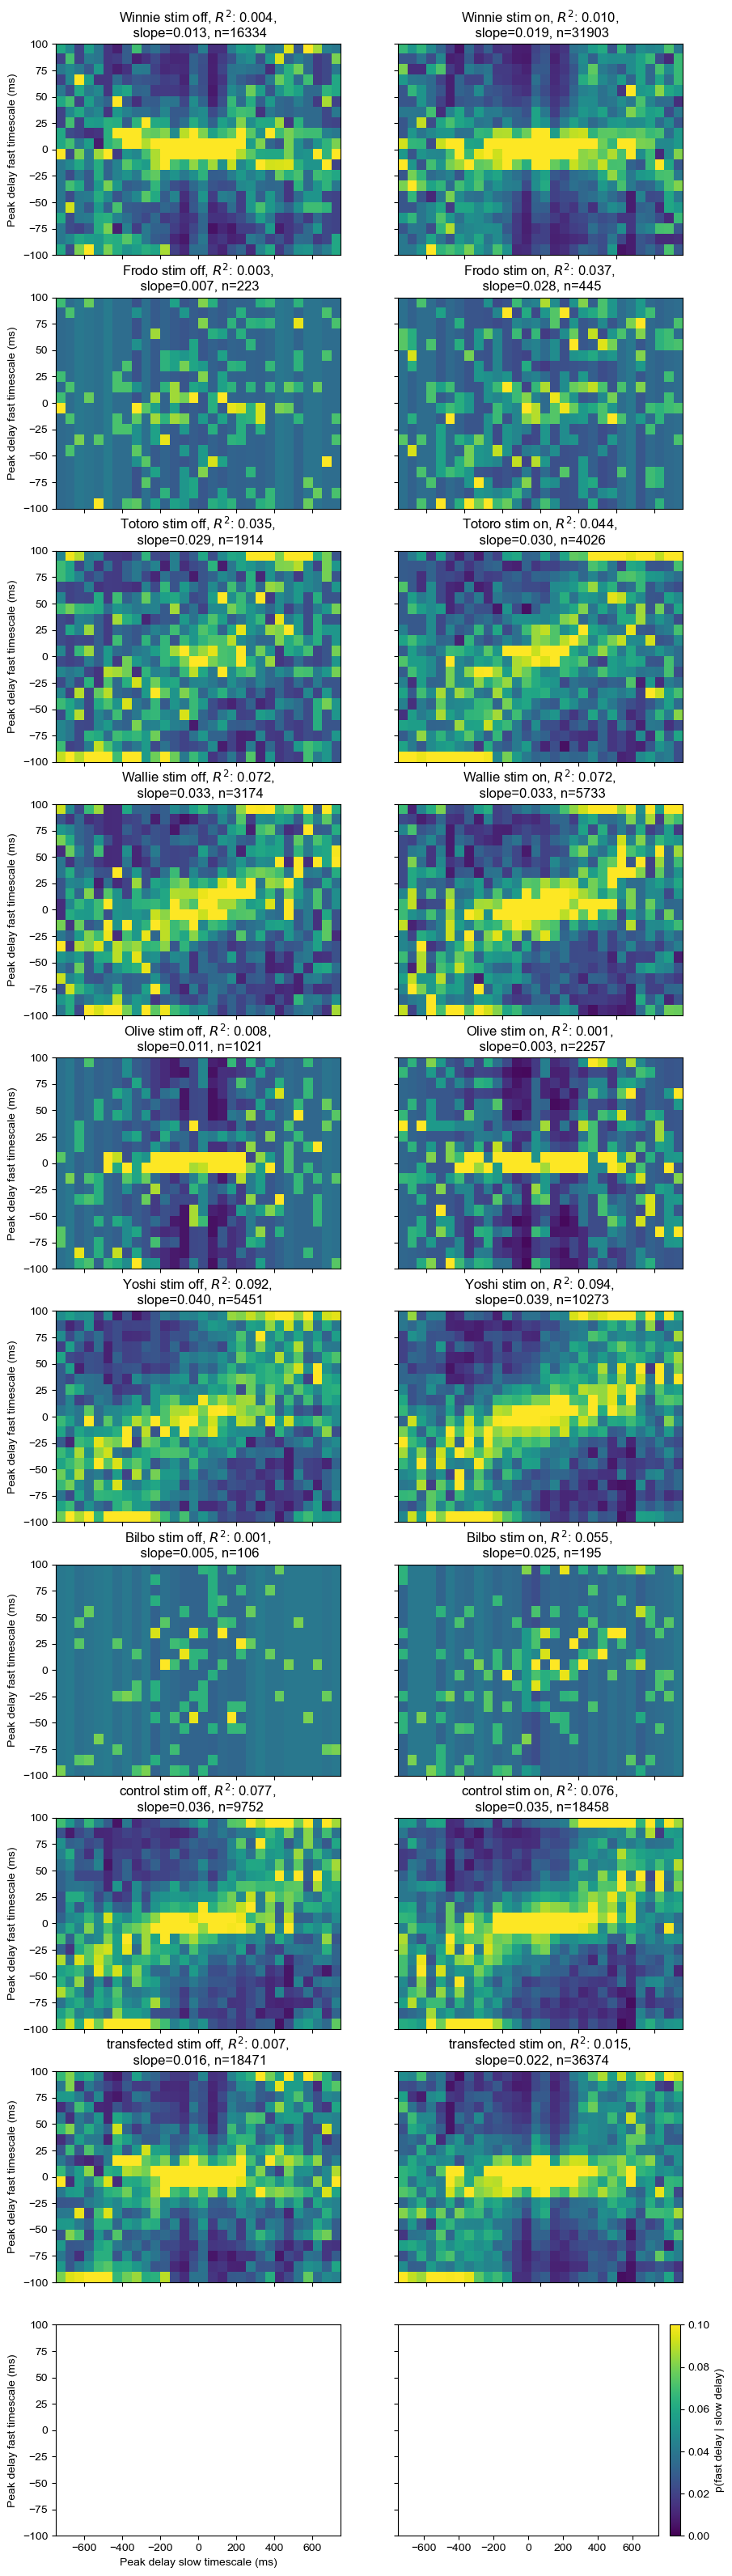

In [ ]:
# import pandas as pd
import matplotlib.pyplot as plt

min_slow_spikes = 100
min_fast_spikes = 50
#############3
upsample = 0
sigma_slow = 5
sigma_fast = 5
log = False
standardize_orders = False
modulo_shift = 0
slow_bin_size = 50
fast_bin_size = 10
plot_ridge = False
long_timescale_thresh = 200
plot_fit = False
correlation_range = 750
# upsample = 300
# sigma_slow = 30
# sigma_fast = 10
# log = False
# standardize_orders = False
# modulo_shift = 0
# slow_bin_size = 10
# fast_bin_size = 1
# plot_ridge = False
# long_timescale_thresh = 200
# correlation_range = 750
# slow_bin_size = 16
# fast_bin_size = 6
# slow_bin_size = 2
# fast_bin_size = 1
heatmap_results = {}
fast_distribution = {}
slow_distribution = {}
counts = {}
correlations = {}
slopes = {}
long_timescale_counts = {}
fig, ax = plt.subplots(
    ncols=2,
    nrows=len(results) + 1,
    sharex=True,
    sharey=True,
    figsize=(10, 4 * (len(results) + 1)),
    # width_ratios=(1, 1, 0.2)
)
for a, animal in zip(ax, results.keys()):
    # if animal == "Winnie":
    #     continue
    heatmap_results[animal] = {}
    fast_distribution[animal] = {}
    slow_distribution[animal] = {}
    counts[animal] = {}
    long_timescale_counts[animal] = {}
    correlations[animal] = {}
    slopes[animal] = {}
    merged_control_df = results[animal]["control"]
    merged_test_df = results[animal]["test"]
    merged_control_df = merged_control_df[
        merged_control_df.n_coincidients_fast >= min_fast_spikes
    ]
    merged_test_df = merged_test_df[
        merged_test_df.n_coincidients_fast >= min_fast_spikes
    ]
    merged_control_df = merged_control_df[
        merged_control_df.n_coincidients_slow >= min_slow_spikes
    ]
    merged_test_df = merged_test_df[
        merged_test_df.n_coincidients_slow >= min_slow_spikes
    ]
    lim_x = correlation_range + 1
    # lim_x = 201
    if standardize_orders:
        bx = np.arange(0, lim_x, slow_bin_size)
    else:
        bx = np.arange(-lim_x, lim_x, slow_bin_size)
    by = np.arange(-120, 120.1, fast_bin_size)
    for a_i, merged_df, cond in zip(
        a, [merged_control_df, merged_test_df], ["stim off", "stim on"]
    ):
        slow_val = merged_df.peak_delay_slow.values.copy()
        # fast_val = merged_df.peak_delay_fast.values.copy()
        fast_val = np.array(
            [get_max_fast_peak_delay(row) for _, row in merged_df.iterrows()]
        )
        raw_slow_val = slow_val.copy()
        raw_fast_val = fast_val.copy()
        counts[animal][cond] = len(merged_df)
        long_timescale_counts[animal][cond] = np.sum(
            np.abs(slow_val > long_timescale_thresh)
        )
        if upsample > 1:
            slow_val = [x for x in slow_val for _ in range(upsample)]
            fast_val = [x for x in fast_val for _ in range(upsample)]
            slow_val = np.array(slow_val) + np.random.normal(
                0, sigma_slow, len(slow_val)
            )
            fast_val = np.array(fast_val) + np.random.normal(
                0, sigma_fast, len(fast_val)
            )
        if standardize_orders:
            ind = np.where(slow_val < 0)[0]
            slow_val[ind] = -slow_val[ind]
            fast_val[ind] = -fast_val[ind]
        if modulo_shift:
            ind = np.where(np.abs(slow_val) < 200)[0]
            steps = np.arange(0, 500, modulo_shift)
            sub_outer = np.subtract.outer(
                slow_val,
                steps,
            )
            min_offset = np.argmin(np.abs(sub_outer), axis=1)
            slow_val = np.array(
                [sub_outer[i, min_offset[i]] for i in range(len(min_offset))]
            )
            slow_val = slow_val[ind]
            fast_val = fast_val[ind]
        dist_slow = np.histogram(slow_val, bins=bx)[0]
        dist_slow = dist_slow / dist_slow.sum()
        slow_distribution[animal][cond] = dist_slow
        dist_fast = np.histogram(fast_val, bins=by)[0]
        dist_fast = dist_fast / dist_fast.sum()
        fast_distribution[animal][cond] = dist_fast
        H, bx, by = np.histogram2d(slow_val, fast_val, bins=(bx, by))
        H = H + 1
        H = H / H.sum(axis=1)[:, None]
        # H = H / H.sum()
        if log:
            H = np.log10(H + 1e-10)  # Log transform to visualize better
            a_i.imshow(
                H.T,
                origin="lower",
                extent=(bx[0], bx[-1], by[0], by[-1]),
                cmap="hot",
                aspect="auto",
                clim=(-2, -1),
            )
        else:
            a_i.imshow(
                H.T,
                origin="lower",
                extent=(bx[0], bx[-1], by[0], by[-1]),
                # cmap="hot",
                aspect="auto",
                clim=(0, 0.1),
                # clim=(0, 0.25),
            )
        if plot_ridge:
            a_i.plot(bx[1:], by[np.argmax(H, axis=1)], c="cyan")
        # ind_corr = np.where(np.abs(raw_slow_val) <= correlation_range)[0]
        ind_corr = np.logical_and(
            np.abs(raw_slow_val) <= correlation_range, np.abs(raw_fast_val) <= 90
        )
        corr = np.corrcoef(
            raw_slow_val[ind_corr],
            raw_fast_val[ind_corr],
        )[0, 1]
        correlations[animal][cond] = corr
        slope = linregress(raw_slow_val[ind_corr], raw_fast_val[ind_corr]).slope
        slopes[animal][cond] = slope
        a_i.set_title(
            f"{animal} {cond}, $R^2$: {corr**2:.3f}, \n slope={slope:.3f}, n={counts[animal][cond]}"
        )
        heatmap_results[animal][cond] = H
        if plot_fit:
            # Fit a line to the data
            x_fit = np.linspace(bx[0], bx[-1], 100)
            lin_fit = linregress(raw_slow_val[ind_corr], raw_fast_val[ind_corr])
            slope = lin_fit.slope
            intercept = lin_fit.intercept
            # Generate y values for the fit line
            y_fit = slope * x_fit + intercept
            a_i.plot(x_fit, y_fit, color="cyan", linestyle="--", linewidth=1)
        # break
# plt.colorbar(label='Counts')
lim = correlation_range
if modulo_shift:
    plt.xlim(-modulo_shift // 2, modulo_shift // 2)
elif standardize_orders:
    plt.xlim(0, lim)
else:
    plt.xlim(-lim, lim)
for a in ax[-1, :-1]:
    # a.set_ylim(-80, 80)
    a.set_ylim(-100, 100)
    xlabel = "Peak delay slow timescale (ms)"
    if modulo_shift:
        xlabel = f"Peak delay slow timescale (ms) modulo {modulo_shift}, shifted"
    a.set_xlabel(xlabel)
for a in ax[:, 0]:
    a.set_ylabel("Peak delay fast timescale (ms)")
    # a.set_xticks(np.arange(-lim, lim + 1, 100))
    # a.set_yticks(np.arange(-80, 81, 20))

im = ax[0, 0].images[0]
if im is not None:
    plt.colorbar(
        im,
        ax=ax[-1, -1],
        orientation="vertical",
        fraction=0.046,
        pad=0.04,
        label="p(fast delay | slow delay)",
    )
plt.rcParams["svg.fonttype"] = "none"
plt.rcParams["font.family"] = "Arial"

In [25]:
fig.savefig(
    "/home/sambray/Documents/MS_analysis_samsplaying/Figures202507/wtrack_heatmaps_peak_delays_noSmoothing_slowFast_v1.svg"
)

In [ ]:
fig.savefig(
    "/home/sambray/Documents/MS_analysis_samsplaying/Figures202507/wtrack_heatmaps_peak_delays_slowFast.svg"
)

<function matplotlib.pyplot.colorbar(mappable: 'ScalarMappable | ColorizingArtist | None' = None, cax: 'matplotlib.axes.Axes | None' = None, ax: 'matplotlib.axes.Axes | Iterable[matplotlib.axes.Axes] | None' = None, **kwargs) -> 'Colorbar'>

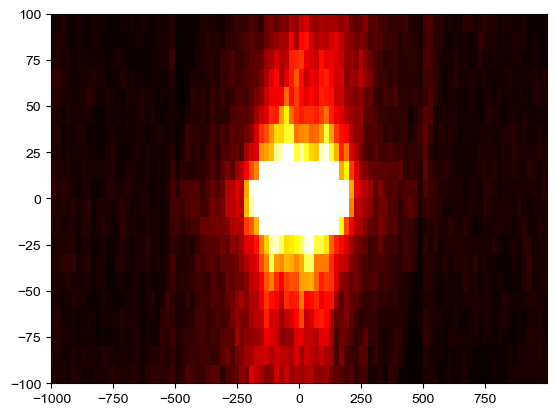

In [501]:
H.shape
# plt.imshow(H.T)
bx.shape, by.shape

plt.imshow(
    H.T,
    origin="lower",
    extent=(bx[0], bx[-1], by[0], by[-1]),
    cmap="hot",
    aspect="auto",
    clim=(0, 0.0025),
)
plt.colorbar

stim off
stim on


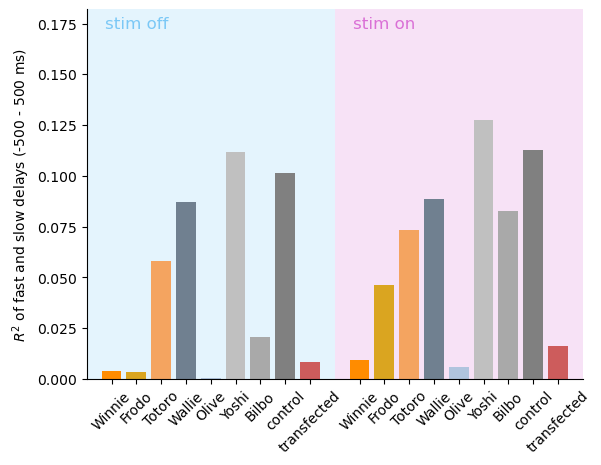

In [273]:
from Style.style_guide import interval_style

fig = plt.figure()

ticks = []
labels = []
for i, cond in enumerate(["stim off", "stim on"]):
    print(cond)
    for j, animal in enumerate(results.keys()):
        # if animal not in correlations:
        #     continue
        corr = correlations[animal][cond] ** 2
        color = animal_style.loc[animal, "color"]
        xloc = i * 10 + j
        ticks.append(xloc)
        labels.append(f"{animal}")
        plt.bar(
            xloc,
            corr,
            color=color,
            # label=animal,
        )
plt.xticks(ticks, labels, rotation=45)
plt.fill_between(
    [-1, 9], 0, 0.2, facecolor=interval_style["control"], alpha=0.2, zorder=-1
)
plt.fill_between(
    [9, 19], 0, 0.2, facecolor=interval_style["test"], alpha=0.2, zorder=-1
)

plt.text(
    1.0,
    0.175,
    "stim off",
    ha="center",
    va="center",
    fontsize=12,
    color=interval_style["control"],
)
plt.text(
    11.0,
    0.175,
    "stim on",
    ha="center",
    va="center",
    fontsize=12,
    color=interval_style["test"],
)
plt.ylabel(
    f"$R^2$ of fast and slow delays ({-correlation_range} - {correlation_range} ms)"
)
plt.xlim(-1, 19)
plt.ylim(0, 0.182)
fig.gca().spines[["top", "right"]].set_visible(False)

# ax.set_title(f"Correlation of slow and fast delays {cond}")
# ax.set_ylabel("Correlation coefficient")
# ax.set_xlabel("Animal")
# ax.axhline(0, ls="--", c="k")
# ax.legend()

stim off
stim on


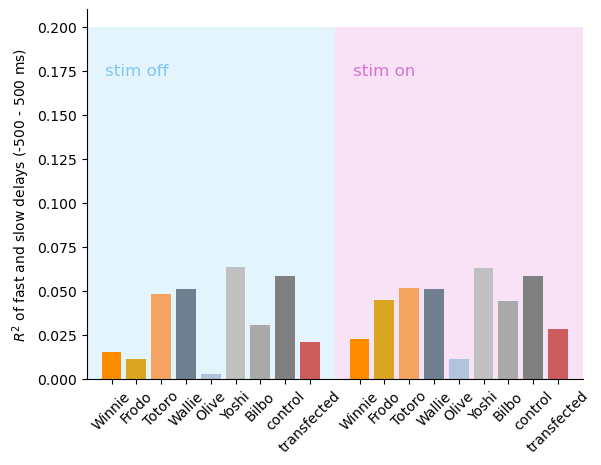

In [275]:
from Style.style_guide import interval_style

fig = plt.figure()

ticks = []
labels = []
for i, cond in enumerate(["stim off", "stim on"]):
    print(cond)
    for j, animal in enumerate(results.keys()):
        # if animal not in correlations:
        #     continue
        slope = slopes[animal][cond]  # **-1
        color = animal_style.loc[animal, "color"]
        xloc = i * 10 + j
        ticks.append(xloc)
        labels.append(f"{animal}")
        plt.bar(
            xloc,
            slope,
            color=color,
            # label=animal,
        )
plt.xticks(ticks, labels, rotation=45)
plt.fill_between(
    [-1, 9], 0, 0.2, facecolor=interval_style["control"], alpha=0.2, zorder=-1
)
plt.fill_between(
    [9, 19], 0, 0.2, facecolor=interval_style["test"], alpha=0.2, zorder=-1
)

plt.text(
    1.0,
    0.175,
    "stim off",
    ha="center",
    va="center",
    fontsize=12,
    color=interval_style["control"],
)
plt.text(
    11.0,
    0.175,
    "stim on",
    ha="center",
    va="center",
    fontsize=12,
    color=interval_style["test"],
)
plt.ylabel(
    f"$R^2$ of fast and slow delays ({-correlation_range} - {correlation_range} ms)"
)
plt.xlim(-1, 19)
# plt.ylim(0, 0.182)
fig.gca().spines[["top", "right"]].set_visible(False)

# ax.set_title(f"Correlation of slow and fast delays {cond}")
# ax.set_ylabel("Correlation coefficient")
# ax.set_xlabel("Animal")
# ax.axhline(0, ls="--", c="k")
# ax.legend()

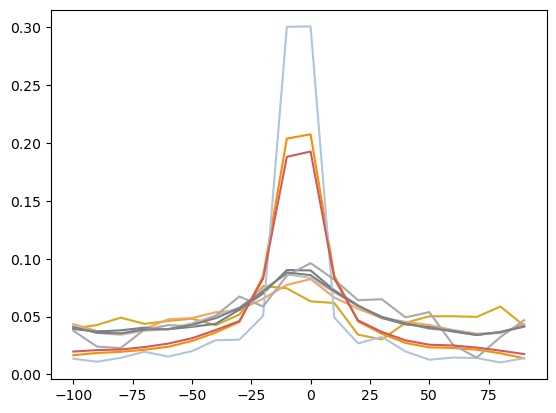

In [378]:
# for animal in slow_distribution:
#     data = slow_distribution[animal]["stim on"]
#     # data = np.log10(data)
#     plt.plot(
#         bx[:-1],
#         data,
#         label=animal,
#         color=animal_style.loc[animal, "color"],
#     )
# plt.ylim(0, 0.03)

for animal in fast_distribution:
    data = fast_distribution[animal]["stim on"]
    # data = np.log10(data)
    plt.plot(
        by[:-1],
        data,
        label=animal,
        color=animal_style.loc[animal, "color"],
    )
# plt.ylim(0, 0.03)

In [239]:
# plt.scatter(
#     slow_val, fast_val,
#     alpha=0.02,
#     s=1,
#     label="control",
#     )

np.corrcoef(slow_val, fast_val)
from scipy.stats import linregress

ind_regress = np.where(np.abs(slow_val) < 500)[0]
slope = linregress(slow_val[ind_regress], fast_val[ind_regress]).slope

In [ ]:
# fig.savefig("peak_delay_heatmaps.svg")

In [484]:
pd.DataFrame(counts)

Winnie  Frodo  Totoro  Wallie  Olive  Yoshi  Bilbo  transfected  \
stim off   16334    223    1914    3174   1021   5451    106        18471   
stim on    31903    445    4026    5733   2257  10273    195        36374   

          control  
stim off     9752  
stim on     18458

In [486]:
pd.DataFrame(long_timescale_counts)

Winnie  Frodo  Totoro  Wallie  Olive  Yoshi  Bilbo  transfected  \
stim off    1626     70     547     988    148   1834     23         2243   
stim on     2911    133    1208    1896    292   3396     72         4252   

          control  
stim off     2993  
stim on      5656

Text(0, 0.5, 'Peak delay fast timescale (ms)')

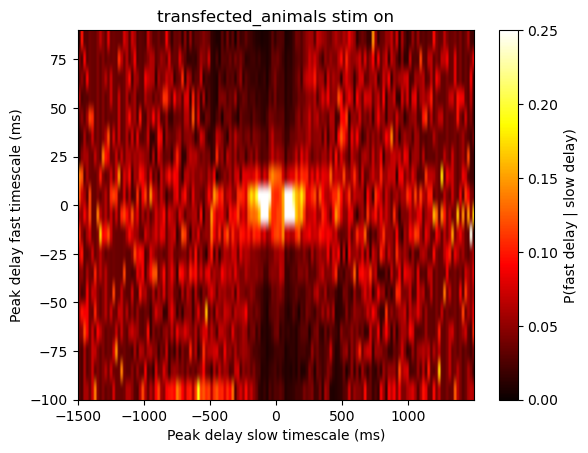

In [172]:
fig = plt.figure()
plt.imshow(
    H.T,
    origin="lower",
    extent=(bx[0], bx[-1], by[0], by[-1]),
    cmap="hot",
    aspect="auto",
    clim=(0, 0.25),
)
plt.title(f"{animal}_animals {cond}")
plt.colorbar(label="P(fast delay | slow delay)")
plt.xlabel("Peak delay slow timescale (ms)")
plt.ylabel("Peak delay fast timescale (ms)")

# fig.savefig("heatmap_colorbar.svg")

# Heirarchical Bootstrap of correlation coefficients (NO OLIVE)

In [12]:
correlation_range = 500
fast_correlation_range = 90
n_boot = 10000

animal_groups = {
    "control": [
        "Yoshi",
        "Wallie",
        # "Bilbo",
    ],
    "targeted": [
        "Winnie",
        # "Frodo",
        "Totoro",
    ],
}

from Style.style_guide import animal_style, interval_style
from Analysis.utils import violin_scatter

In [8]:
from tqdm import tqdm

bootstrap_results = {}

for group, animals in animal_groups.items():
    bootstrap_results[group] = {}
    for cond in ["control", "test"]:
        temp_results = {}
        for animal in animals:
            df = results[animal][cond].copy()
            # df = df[np.logical_and(
            #     np.abs(df.peak_delay_fast) < fast_correlation_range,
            #     np.abs(df.peak_delay_slow) < correlation_range
            #     )
            #         ]
            slow_val = df.peak_delay_slow.values.copy()
            fast_val = np.array(
                [get_max_fast_peak_delay(row) for _, row in df.iterrows()]
            )
            ind_valid = np.logical_and(
                np.abs(slow_val) < correlation_range,
                np.abs(fast_val) < fast_correlation_range,
            )
            df = pd.DataFrame(
                {
                    "peak_delay_slow": slow_val[ind_valid],
                    "peak_delay_fast": fast_val[ind_valid],
                }
            )

            temp_results[animal] = df

        c_ = []
        for _ in tqdm(range(n_boot), desc=f"Bootstrapping {group} {cond}"):
            animal_samples = np.random.choice(animals, len(animals), replace=True)
            slow_val = []
            fast_val = []
            for animal in animal_samples:
                df = temp_results[animal]
                pair_samples = np.random.choice(len(df), len(df), replace=True)
                slow_val.extend(df.peak_delay_slow.values[pair_samples])
                fast_val.extend(df.peak_delay_fast.values[pair_samples])
            corr = np.corrcoef(slow_val, fast_val)[0, 1]
            c_.append(corr)
        c_ = np.array(c_)
        bootstrap_results[group][cond] = c_

Bootstrapping targeted test: 100%|██████████| 10000/10000 [01:10<00:00, 141.11it/s]


interval effect (control animals) p-value: 0.413
interval effect (targeted animals) p-value: 0.254
group effect (control interval) p-value: 0.0011
group effect (test interval) p-value: 0.0010


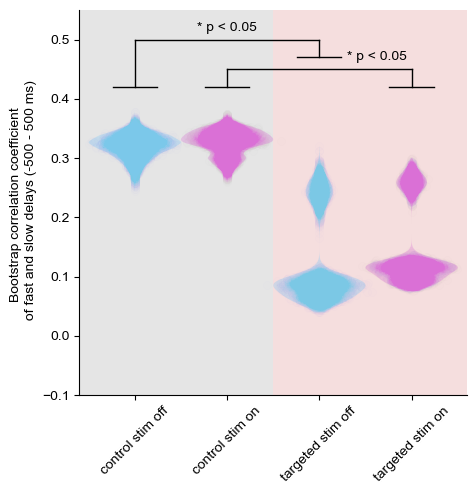

In [ ]:
ticks = []
labels = []

fig = plt.figure(figsize=(5, 5))
for i, group in enumerate(bootstrap_results):
    for j, cond in enumerate(bootstrap_results[group]):
        scores = bootstrap_results[group][cond]
        color = (
            interval_style["control"] if cond == "control" else interval_style["test"]
        )
        cond_name = "stim off" if cond == "control" else "stim on"
        xloc = i + j * 0.5
        violin_scatter(scores, pos=[xloc], color=color)
        ticks.append(xloc)
        labels.append(f"{group} {cond_name}")


def test_diff_of_bootstrap_dist(dist1, dist2):
    diff = np.subtract.outer(dist1, dist2)
    diff = np.ravel(diff)
    # standarize the sign of the difference
    if np.mean(diff) < 0:
        diff = -diff
    p_val = np.sum(diff < 0) / diff.size
    return p_val


# test for interval driven difference in each animal group
for i, group in enumerate(bootstrap_results):
    dists = [bootstrap_results[group]["control"], bootstrap_results[group]["test"]]
    p_val = test_diff_of_bootstrap_dist(*dists)
    print(f"interval effect ({group} animals) p-value: {p_val:.3f}")
# test for difference between control and transfected for each interval
for i, cond in enumerate(["control", "test"]):
    dists = [
        bootstrap_results["control"][cond],
        bootstrap_results["targeted"][cond],
    ]
    p_val = test_diff_of_bootstrap_dist(*dists)
    print(f"group effect ({cond} interval) p-value: {p_val:.4f}")


# indicate sig difference
y_max = 0.42
y_bridge = 0.45
x1 = ticks[1]
x2 = ticks[3]
bar_rng = 0.12
plt.plot([x1, x2], [y_bridge, y_bridge], color="k", lw=1)
plt.plot([x1, x1], [y_max, y_bridge], color="k", lw=1)
plt.plot([x2, x2], [y_max, y_bridge], color="k", lw=1)
plt.plot([x1 - bar_rng, x1 + bar_rng], [y_max, y_max], color="k", lw=1)
plt.plot([x2 - bar_rng, x2 + bar_rng], [y_max, y_max], color="k", lw=1)
plt.text(
    x1 + (x2 - x1) * 0.65,
    y_bridge + 0.02,
    "* p < 0.05",
    ha="left",
    va="center",
    fontsize=10,
    color="k",
)

# indicate sig difference
y_max = 0.42, 0.47
y_bridge = 0.50
x1 = ticks[0]
x2 = ticks[2]
plt.plot([x1, x2], [y_bridge, y_bridge], color="k", lw=1)
plt.plot([x1, x1], [y_max[0], y_bridge], color="k", lw=1)
plt.plot([x2, x2], [y_max[1], y_bridge], color="k", lw=1)
plt.plot([x1 - bar_rng, x1 + bar_rng], [y_max[0], y_max[0]], color="k", lw=1)
plt.plot([x2 - bar_rng, x2 + bar_rng], [y_max[1], y_max[1]], color="k", lw=1)
plt.text(
    (x1 + x2) / 2,
    y_bridge + 0.02,
    "* p < 0.05",
    ha="center",
    va="center",
    fontsize=10,
    color="k",
)


plt.xticks(ticks, labels, rotation=45)
plt.ylabel(
    f"Bootstrap correlation coefficient \n of fast and slow delays ({-correlation_range} - {correlation_range} ms)"
)
plt.xlim(-0.3, len(ticks) / 2 - 0.2)

plt.fill_between(
    [-1, 0.75],
    -0.2,
    0.6,
    facecolor=animal_style.loc["control", "color"],
    alpha=0.2,
    zorder=-1,
)
plt.fill_between(
    [0.75, 2.25],
    -0.2,
    0.6,
    facecolor=animal_style.loc["transfected", "color"],
    alpha=0.2,
    zorder=-1,
)
plt.ylim(-0.1, 0.55)

fig.gca().spines[["top", "right"]].set_visible(False)

plt.rcParams["svg.fonttype"] = "none"
plt.rcParams["font.family"] = "Arial"
# fig.savefig(
#     "/home/sambray/Documents/MS_analysis_samsplaying/Figures202507/wtrack_slow_fast_heirarchical_bootstrap_correlation_coefficients.svg"
# )

interval effect (control animals) p-value: 0.413
interval effect (targeted animals) p-value: 0.254
group effect (control interval) p-value: 0.001
group effect (test interval) p-value: 0.001


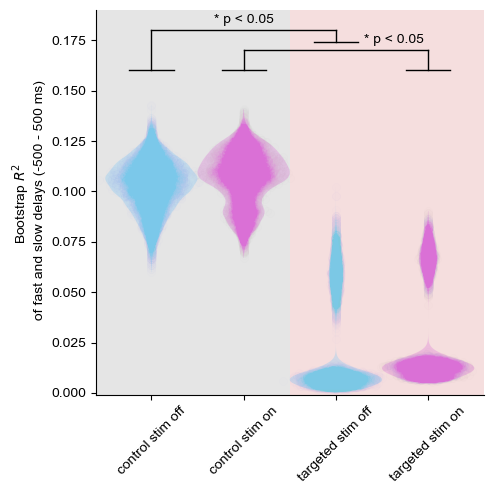

In [17]:
ticks = []
labels = []

fig = plt.figure(figsize=(5, 5))
for i, group in enumerate(bootstrap_results):
    for j, cond in enumerate(bootstrap_results[group]):
        scores = bootstrap_results[group][cond] ** 2
        color = (
            interval_style["control"] if cond == "control" else interval_style["test"]
        )
        cond_name = "stim off" if cond == "control" else "stim on"
        xloc = i + j * 0.5
        violin_scatter(scores, pos=[xloc], color=color)
        ticks.append(xloc)
        labels.append(f"{group} {cond_name}")


# test for interval driven difference in each animal group
for i, group in enumerate(bootstrap_results):
    dists = [
        bootstrap_results[group]["control"] ** 2,
        bootstrap_results[group]["test"] ** 2,
    ]
    p_val = test_diff_of_bootstrap_dist(*dists)
    print(f"interval effect ({group} animals) p-value: {p_val:.3f}")
# test for difference between control and transfected for each interval
for i, cond in enumerate(["control", "test"]):
    dists = [
        bootstrap_results["control"][cond] ** 2,
        bootstrap_results["targeted"][cond] ** 2,
    ]
    p_val = test_diff_of_bootstrap_dist(*dists)
    print(f"group effect ({cond} interval) p-value: {p_val:.3f}")

# indicate sig difference
y_max = 0.16
y_bridge = 0.17
x1 = ticks[1]
x2 = ticks[3]
bar_rng = 0.12
plt.plot([x1, x2], [y_bridge, y_bridge], color="k", lw=1)
plt.plot([x1, x1], [y_max, y_bridge], color="k", lw=1)
plt.plot([x2, x2], [y_max, y_bridge], color="k", lw=1)
plt.plot([x1 - bar_rng, x1 + bar_rng], [y_max, y_max], color="k", lw=1)
plt.plot([x2 - bar_rng, x2 + bar_rng], [y_max, y_max], color="k", lw=1)
plt.text(
    x1 + (x2 - x1) * 0.65,
    y_bridge + 0.005,
    "* p < 0.05",
    ha="left",
    va="center",
    fontsize=10,
    color="k",
)

# indicate sig difference
y_max = 0.16, 0.174
y_bridge = 0.18
x1 = ticks[0]
x2 = ticks[2]
plt.plot([x1, x2], [y_bridge, y_bridge], color="k", lw=1)
plt.plot([x1, x1], [y_max[0], y_bridge], color="k", lw=1)
plt.plot([x2, x2], [y_max[1], y_bridge], color="k", lw=1)
plt.plot([x1 - bar_rng, x1 + bar_rng], [y_max[0], y_max[0]], color="k", lw=1)
plt.plot([x2 - bar_rng, x2 + bar_rng], [y_max[1], y_max[1]], color="k", lw=1)
plt.text(
    (x1 + x2) / 2,
    y_bridge + 0.005,
    "* p < 0.05",
    ha="center",
    va="center",
    fontsize=10,
    color="k",
)

plt.xticks(ticks, labels, rotation=45)
plt.ylabel(
    f"Bootstrap $R^2$ \n of fast and slow delays ({-correlation_range} - {correlation_range} ms)"
)
plt.xlim(-0.3, len(ticks) / 2 - 0.2)

plt.fill_between(
    [-1, 0.75],
    -0.2,
    0.2,
    facecolor=animal_style.loc["control", "color"],
    alpha=0.2,
    zorder=-1,
)
plt.fill_between(
    [0.75, 2.25],
    -0.2,
    0.2,
    facecolor=animal_style.loc["transfected", "color"],
    alpha=0.2,
    zorder=-1,
)
plt.ylim(-0.001, 0.19)

fig.gca().spines[["top", "right"]].set_visible(False)

fig.savefig(
    "/home/sambray/Documents/MS_analysis_samsplaying/Figures202507/wtrack_heirarchical_bootstrap_Rsquared.svg"
)

interval effect (control animals) p-value: 0.306
interval effect (targeted animals) p-value: 0.229
group effect (control interval) p-value: 0.001
group effect (test interval) p-value: 0.004


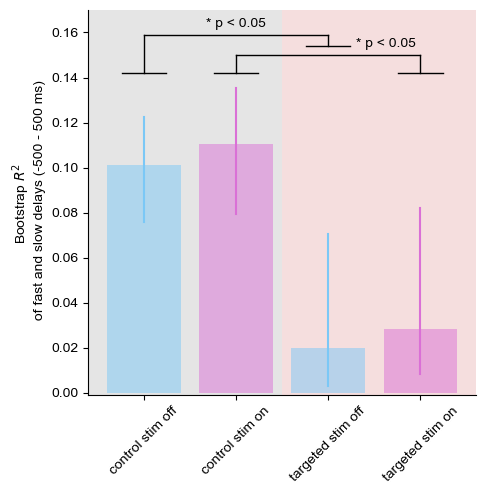

In [496]:
ticks = []
labels = []

fig = plt.figure(figsize=(5, 5))
for i, group in enumerate(bootstrap_results):
    for j, cond in enumerate(bootstrap_results[group]):
        scores = bootstrap_results[group][cond] ** 2
        color = (
            interval_style["control"] if cond == "control" else interval_style["test"]
        )
        cond_name = "stim off" if cond == "control" else "stim on"
        xloc = i + j * 0.5
        plt.bar(
            xloc,
            scores.mean(),
            color=color,
            label=f"{group} {cond_name}",
            width=0.4,
            alpha=0.5,
        )
        plt.plot([xloc, xloc], np.percentile(scores, [2.5, 97.5]), color=color)
        ticks.append(xloc)
        labels.append(f"{group} {cond_name}")


# test for interval driven difference in each animal group
for i, group in enumerate(bootstrap_results):
    dists = [
        bootstrap_results[group]["control"] ** 2,
        bootstrap_results[group]["test"] ** 2,
    ]
    p_val = test_diff_of_bootstrap_dist(*dists)
    print(f"interval effect ({group} animals) p-value: {p_val:.3f}")
# test for difference between control and transfected for each interval
for i, cond in enumerate(["control", "test"]):
    dists = [
        bootstrap_results["control"][cond] ** 2,
        bootstrap_results["targeted"][cond] ** 2,
    ]
    p_val = test_diff_of_bootstrap_dist(*dists)
    print(f"group effect ({cond} interval) p-value: {p_val:.3f}")

# indicate sig difference
y_max = 0.142
y_bridge = 0.15
x1 = ticks[1]
x2 = ticks[3]
bar_rng = 0.12
plt.plot([x1, x2], [y_bridge, y_bridge], color="k", lw=1)
plt.plot([x1, x1], [y_max, y_bridge], color="k", lw=1)
plt.plot([x2, x2], [y_max, y_bridge], color="k", lw=1)
plt.plot([x1 - bar_rng, x1 + bar_rng], [y_max, y_max], color="k", lw=1)
plt.plot([x2 - bar_rng, x2 + bar_rng], [y_max, y_max], color="k", lw=1)
plt.text(
    x1 + (x2 - x1) * 0.65,
    y_bridge + 0.005,
    "* p < 0.05",
    ha="left",
    va="center",
    fontsize=10,
    color="k",
)

# indicate sig difference
y_max = 0.142, 0.154
y_bridge = 0.159
x1 = ticks[0]
x2 = ticks[2]
plt.plot([x1, x2], [y_bridge, y_bridge], color="k", lw=1)
plt.plot([x1, x1], [y_max[0], y_bridge], color="k", lw=1)
plt.plot([x2, x2], [y_max[1], y_bridge], color="k", lw=1)
plt.plot([x1 - bar_rng, x1 + bar_rng], [y_max[0], y_max[0]], color="k", lw=1)
plt.plot([x2 - bar_rng, x2 + bar_rng], [y_max[1], y_max[1]], color="k", lw=1)
plt.text(
    (x1 + x2) / 2,
    y_bridge + 0.005,
    "* p < 0.05",
    ha="center",
    va="center",
    fontsize=10,
    color="k",
)


plt.xticks(ticks, labels, rotation=45)
plt.ylabel(
    f"Bootstrap $R^2$ \n of fast and slow delays ({-correlation_range} - {correlation_range} ms)"
)
plt.xlim(-0.3, len(ticks) / 2 - 0.2)

plt.fill_between(
    [-1, 0.75],
    -0.2,
    0.2,
    facecolor=animal_style.loc["control", "color"],
    alpha=0.2,
    zorder=-1,
)
plt.fill_between(
    [0.75, 2.25],
    -0.2,
    0.2,
    facecolor=animal_style.loc["transfected", "color"],
    alpha=0.2,
    zorder=-1,
)
plt.ylim(-0.001, 0.17)

fig.gca().spines[["top", "right"]].set_visible(False)

fig.savefig(
    "/home/sambray/Documents/MS_analysis_samsplaying/Figures_20250501/bootstrap_correlation_coefficients_ExcludeAnimals_Rsquared_bar.svg"
)

### Pooling stim on off

In [37]:
correlation_range = 500
fast_correlation_range = 90
n_boot = 10000

animal_groups = {
    "control": [
        "Yoshi",
        "Wallie",
        # "Bilbo",
    ],
    "targeted": [
        "Winnie",
        # "Frodo",
        "Totoro",
    ],
}

from Style.style_guide import animal_style, interval_style
from Analysis.utils import violin_scatter


def test_diff_of_bootstrap_dist(dist1, dist2):
    diff = np.subtract.outer(dist1, dist2)
    diff = np.ravel(diff)
    # standarize the sign of the difference
    if np.mean(diff) < 0:
        diff = -diff
    p_val = np.sum(diff < 0) / diff.size
    return p_val

In [38]:
from tqdm import tqdm

bootstrap_results = {}

for group, animals in animal_groups.items():
    # bootstrap_results[group] = {}

    temp_results = {}
    for animal in animals:
        temp_slow = []
        temp_fast = []
        for cond in ["control", "test"]:
            df = results[animal][cond].copy()
            # df = df[np.logical_and(
            #     np.abs(df.peak_delay_fast) < fast_correlation_range,
            #     np.abs(df.peak_delay_slow) < correlation_range
            #     )
            #         ]
            slow_val = df.peak_delay_slow.values.copy()
            fast_val = np.array(
                [get_max_fast_peak_delay(row) for _, row in df.iterrows()]
            )
            # fast_val = fast_val%100

            ind_valid = np.logical_and(
                np.abs(slow_val) < correlation_range,
                np.abs(fast_val) < fast_correlation_range,
            )
            temp_slow.extend(slow_val[ind_valid])
            temp_fast.extend(fast_val[ind_valid])

        df = pd.DataFrame(
            {
                "peak_delay_slow": temp_slow,
                "peak_delay_fast": temp_fast,
            }
        )

        temp_results[animal] = df

    c_ = []
    for _ in tqdm(range(n_boot), desc=f"Bootstrapping {group}"):
        animal_samples = np.random.choice(animals, len(animals), replace=True)
        slow_val = []
        fast_val = []
        for animal in animal_samples:
            df = temp_results[animal]
            pair_samples = np.random.choice(len(df), len(df), replace=True)
            slow_val.extend(df.peak_delay_slow.values[pair_samples])
            fast_val.extend(df.peak_delay_fast.values[pair_samples])
        corr = np.corrcoef(slow_val, fast_val)[0, 1]
        c_.append(corr)
    c_ = np.array(c_)
    bootstrap_results[group] = c_

Bootstrapping targeted: 100%|██████████| 10000/10000 [01:38<00:00, 102.03it/s]


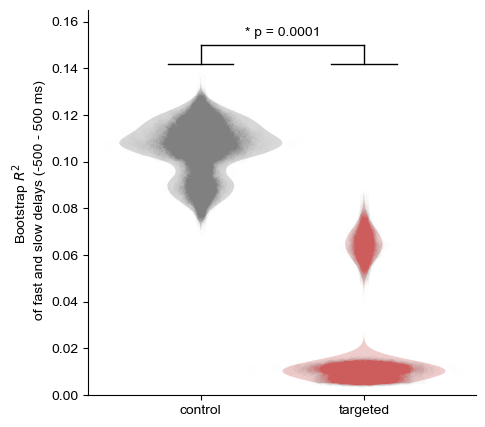

In [ ]:
fig = plt.figure(figsize=(5, 5))
for i, group in enumerate(bootstrap_results):
    scores = bootstrap_results[group] ** 2  # square the scores
    color = animal_style.loc[group if group == "control" else "transfected", "color"]
    violin_scatter(scores, pos=[i / 2], color=color)


plt.xticks([0, 0.5], ["control", "targeted"], rotation=0)
plt.ylabel(
    f"Bootstrap $R^2$ \n of fast and slow delays ({-correlation_range} - {correlation_range} ms)"
)

p_val = test_diff_of_bootstrap_dist(
    bootstrap_results["control"], bootstrap_results["targeted"]
)

# indicate sig difference
y_max = 0.142
y_bridge = 0.15
x1 = 0
x2 = 0.5
bar_rng = 0.1
plt.plot([x1, x2], [y_bridge, y_bridge], color="k", lw=1)
plt.plot([x1, x1], [y_max, y_bridge], color="k", lw=1)
plt.plot([x2, x2], [y_max, y_bridge], color="k", lw=1)
plt.plot([x1 - bar_rng, x1 + bar_rng], [y_max, y_max], color="k", lw=1)
plt.plot([x2 - bar_rng, x2 + bar_rng], [y_max, y_max], color="k", lw=1)
plt.text(
    x1 + (x2 - x1) * 0.5,
    y_bridge + 0.005,
    f"* p = {p_val:.4f}",
    ha="center",
    va="center",
    fontsize=10,
    color="k",
)
plt.ylim(0, 0.165)
fig.gca().spines[["top", "right"]].set_visible(False)

fig.savefig(
    "/home/sambray/Documents/MS_analysis_samsplaying/Figures202507/bootstrap_slowFast_ExcludeAnimals_Rsquared_POOLED.svg"
)

# Heirarchical Bootstrap Correlation Coefficients (WITH OLIVE)

In [465]:
correlation_range = 500
fast_correlation_range = 90
n_boot = 10000

animal_groups = {
    "control": [
        "Yoshi",
        "Wallie",
        "Bilbo",
        "Olive",
    ],
    "targeted": ["Winnie", "Frodo", "Totoro"],
}

In [466]:
from tqdm import tqdm

bootstrap_results = {}

for group, animals in animal_groups.items():
    bootstrap_results[group] = {}
    for cond in ["control", "test"]:
        temp_results = {}
        for animal in animals:
            df = results[animal][cond].copy()
            # df = df[np.logical_and(
            #     np.abs(df.peak_delay_fast) < fast_correlation_range,
            #     np.abs(df.peak_delay_slow) < correlation_range
            #     )
            #         ]
            slow_val = df.peak_delay_slow.values.copy()
            fast_val = np.array(
                [get_max_fast_peak_delay(row) for _, row in df.iterrows()]
            )
            ind_valid = np.logical_and(
                np.abs(slow_val) < correlation_range,
                np.abs(fast_val) < fast_correlation_range,
            )
            df = pd.DataFrame(
                {
                    "peak_delay_slow": slow_val[ind_valid],
                    "peak_delay_fast": fast_val[ind_valid],
                }
            )

            temp_results[animal] = df

        c_ = []
        for _ in tqdm(range(n_boot), desc=f"Bootstrapping {group} {cond}"):
            animal_samples = np.random.choice(animals, len(animals), replace=True)
            slow_val = []
            fast_val = []
            for animal in animal_samples:
                df = temp_results[animal]
                pair_samples = np.random.choice(len(df), len(df), replace=True)
                slow_val.extend(df.peak_delay_slow.values[pair_samples])
                fast_val.extend(df.peak_delay_fast.values[pair_samples])
            corr = np.corrcoef(slow_val, fast_val)[0, 1]
            c_.append(corr)
        c_ = np.array(c_)
        bootstrap_results[group][cond] = c_

Bootstrapping targeted test: 100%|██████████| 10000/10000 [01:31<00:00, 109.21it/s]


In [ ]:
def is_boot_sig_diff(dist1, dist2):


interval effect (control animals) p-value: 0.362
interval effect (targeted animals) p-value: 0.242
group effect (control interval) p-value: 0.074
group effect (test interval) p-value: 0.085


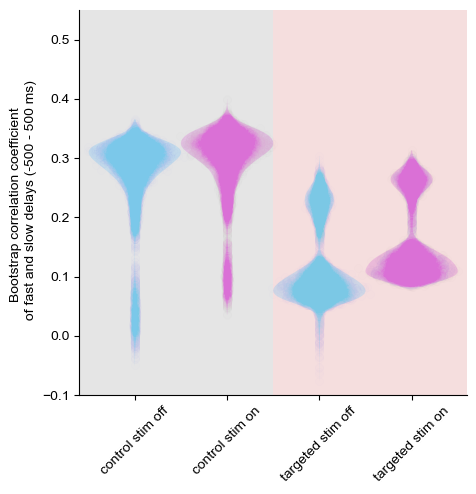

In [473]:
ticks = []
labels = []

fig = plt.figure(figsize=(5, 5))
for i, group in enumerate(bootstrap_results):
    for j, cond in enumerate(bootstrap_results[group]):
        scores = bootstrap_results[group][cond]
        color = (
            interval_style["control"] if cond == "control" else interval_style["test"]
        )
        cond_name = "stim off" if cond == "control" else "stim on"
        xloc = i + j * 0.5
        violin_scatter(scores, pos=[xloc], color=color)
        ticks.append(xloc)
        labels.append(f"{group} {cond_name}")


def test_diff_of_bootstrap_dist(dist1, dist2):
    diff = np.subtract.outer(dist1, dist2)
    diff = np.ravel(diff)
    # standarize the sign of the difference
    if np.mean(diff) < 0:
        diff = -diff
    p_val = np.sum(diff < 0) / diff.size
    return p_val


# test for interval driven difference in each animal group
for i, group in enumerate(bootstrap_results):
    dists = [bootstrap_results[group]["control"], bootstrap_results[group]["test"]]
    p_val = test_diff_of_bootstrap_dist(*dists)
    print(f"interval effect ({group} animals) p-value: {p_val:.3f}")
# test for difference between control and transfected for each interval
for i, cond in enumerate(["control", "test"]):
    dists = [
        bootstrap_results["control"][cond],
        bootstrap_results["targeted"][cond],
    ]
    p_val = test_diff_of_bootstrap_dist(*dists)
    print(f"group effect ({cond} interval) p-value: {p_val:.3f}")


# # indicate sig difference
# y_max = 0.42
# y_bridge = 0.45
# x1 = ticks[1]
# x2 = ticks[3]
# bar_rng = 0.12
# plt.plot([x1, x2], [y_bridge, y_bridge], color="k", lw=1)
# plt.plot([x1, x1], [y_max, y_bridge], color="k", lw=1)
# plt.plot([x2, x2], [y_max, y_bridge], color="k", lw=1)
# plt.plot([x1 - bar_rng, x1 + bar_rng], [y_max, y_max], color="k", lw=1)
# plt.plot([x2 - bar_rng, x2 + bar_rng], [y_max, y_max], color="k", lw=1)
# plt.text(
#     x1 + (x2 - x1) * 0.65,
#     y_bridge + 0.02,
#     "* p < 0.05",
#     ha="left",
#     va="center",
#     fontsize=10,
#     color="k",
# )

# # indicate sig difference
# y_max = 0.42, 0.47
# y_bridge = 0.50
# x1 = ticks[0]
# x2 = ticks[2]
# plt.plot([x1, x2], [y_bridge, y_bridge], color="k", lw=1)
# plt.plot([x1, x1], [y_max[0], y_bridge], color="k", lw=1)
# plt.plot([x2, x2], [y_max[1], y_bridge], color="k", lw=1)
# plt.plot([x1 - bar_rng, x1 + bar_rng], [y_max[0], y_max[0]], color="k", lw=1)
# plt.plot([x2 - bar_rng, x2 + bar_rng], [y_max[1], y_max[1]], color="k", lw=1)
# plt.text(
#     (x1 + x2) / 2,
#     y_bridge + 0.02,
#     "* p < 0.05",
#     ha="center",
#     va="center",
#     fontsize=10,
#     color="k",
# )


plt.xticks(ticks, labels, rotation=45)
plt.ylabel(
    f"Bootstrap correlation coefficient \n of fast and slow delays ({-correlation_range} - {correlation_range} ms)"
)
plt.xlim(-0.3, len(ticks) / 2 - 0.2)

plt.fill_between(
    [-1, 0.75],
    -0.2,
    0.6,
    facecolor=animal_style.loc["control", "color"],
    alpha=0.2,
    zorder=-1,
)
plt.fill_between(
    [0.75, 2.25],
    -0.2,
    0.6,
    facecolor=animal_style.loc["transfected", "color"],
    alpha=0.2,
    zorder=-1,
)
plt.ylim(-0.1, 0.55)

fig.gca().spines[["top", "right"]].set_visible(False)

plt.rcParams["svg.fonttype"] = "none"
plt.rcParams["font.family"] = "Arial"
fig.savefig(
    "/home/sambray/Documents/MS_analysis_samsplaying/Figures_20250501/bootstrap_correlation_coefficients_WITHOlive.pdf"
)

interval effect (control animals) p-value: 0.362
interval effect (targeted animals) p-value: 0.242
group effect (control interval) p-value: 0.074
group effect (test interval) p-value: 0.085


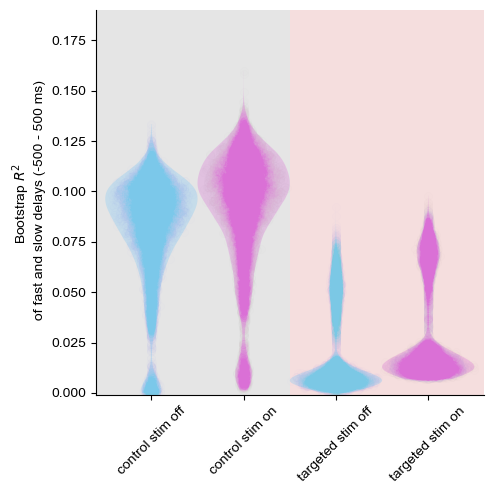

In [472]:
ticks = []
labels = []

fig = plt.figure(figsize=(5, 5))
for i, group in enumerate(bootstrap_results):
    for j, cond in enumerate(bootstrap_results[group]):
        scores = bootstrap_results[group][cond] ** 2
        color = (
            interval_style["control"] if cond == "control" else interval_style["test"]
        )
        cond_name = "stim off" if cond == "control" else "stim on"
        xloc = i + j * 0.5
        violin_scatter(scores, pos=[xloc], color=color)
        ticks.append(xloc)
        labels.append(f"{group} {cond_name}")


# test for interval driven difference in each animal group
for i, group in enumerate(bootstrap_results):
    dists = [
        bootstrap_results[group]["control"] ** 2,
        bootstrap_results[group]["test"] ** 2,
    ]
    p_val = test_diff_of_bootstrap_dist(*dists)
    print(f"interval effect ({group} animals) p-value: {p_val:.3f}")
# test for difference between control and transfected for each interval
for i, cond in enumerate(["control", "test"]):
    dists = [
        bootstrap_results["control"][cond] ** 2,
        bootstrap_results["targeted"][cond] ** 2,
    ]
    p_val = test_diff_of_bootstrap_dist(*dists)
    print(f"group effect ({cond} interval) p-value: {p_val:.3f}")

# # indicate sig difference
# y_max = 0.16
# y_bridge = 0.17
# x1 = ticks[1]
# x2 = ticks[3]
# bar_rng = 0.12
# plt.plot([x1, x2], [y_bridge, y_bridge], color="k", lw=1)
# plt.plot([x1, x1], [y_max, y_bridge], color="k", lw=1)
# plt.plot([x2, x2], [y_max, y_bridge], color="k", lw=1)
# plt.plot([x1 - bar_rng, x1 + bar_rng], [y_max, y_max], color="k", lw=1)
# plt.plot([x2 - bar_rng, x2 + bar_rng], [y_max, y_max], color="k", lw=1)
# plt.text(
#     x1 + (x2 - x1) * 0.65,
#     y_bridge + 0.005,
#     "* p < 0.05",
#     ha="left",
#     va="center",
#     fontsize=10,
#     color="k",
# )

# # indicate sig difference
# y_max = 0.16, 0.174
# y_bridge = 0.18
# x1 = ticks[0]
# x2 = ticks[2]
# plt.plot([x1, x2], [y_bridge, y_bridge], color="k", lw=1)
# plt.plot([x1, x1], [y_max[0], y_bridge], color="k", lw=1)
# plt.plot([x2, x2], [y_max[1], y_bridge], color="k", lw=1)
# plt.plot([x1 - bar_rng, x1 + bar_rng], [y_max[0], y_max[0]], color="k", lw=1)
# plt.plot([x2 - bar_rng, x2 + bar_rng], [y_max[1], y_max[1]], color="k", lw=1)
# plt.text(
#     (x1 + x2) / 2,
#     y_bridge + 0.005,
#     "* p < 0.05",
#     ha="center",
#     va="center",
#     fontsize=10,
#     color="k",
# )

plt.xticks(ticks, labels, rotation=45)
plt.ylabel(
    f"Bootstrap $R^2$ \n of fast and slow delays ({-correlation_range} - {correlation_range} ms)"
)
plt.xlim(-0.3, len(ticks) / 2 - 0.2)

plt.fill_between(
    [-1, 0.75],
    -0.2,
    0.2,
    facecolor=animal_style.loc["control", "color"],
    alpha=0.2,
    zorder=-1,
)
plt.fill_between(
    [0.75, 2.25],
    -0.2,
    0.2,
    facecolor=animal_style.loc["transfected", "color"],
    alpha=0.2,
    zorder=-1,
)
plt.ylim(-0.001, 0.19)

fig.gca().spines[["top", "right"]].set_visible(False)

fig.savefig(
    "/home/sambray/Documents/MS_analysis_samsplaying/Figures_20250501/bootstrap_correlation_coefficients_WITHOlive_Rsquared.pdf"
)

interval effect (control animals) p-value: 0.362
interval effect (targeted animals) p-value: 0.242
group effect (control interval) p-value: 0.074
group effect (test interval) p-value: 0.085


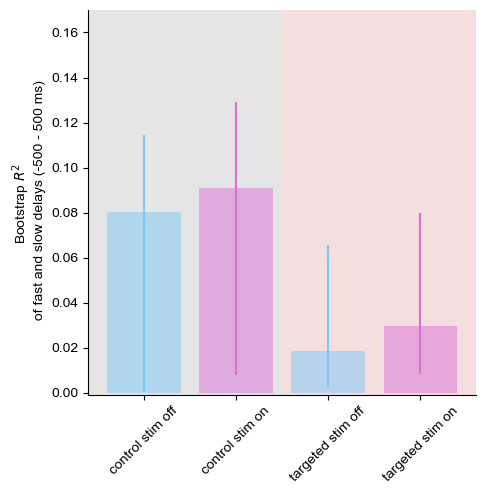

In [471]:
ticks = []
labels = []

fig = plt.figure(figsize=(5, 5))
for i, group in enumerate(bootstrap_results):
    for j, cond in enumerate(bootstrap_results[group]):
        scores = bootstrap_results[group][cond] ** 2
        color = (
            interval_style["control"] if cond == "control" else interval_style["test"]
        )
        cond_name = "stim off" if cond == "control" else "stim on"
        xloc = i + j * 0.5
        plt.bar(
            xloc,
            scores.mean(),
            color=color,
            label=f"{group} {cond_name}",
            width=0.4,
            alpha=0.5,
        )
        plt.plot([xloc, xloc], np.percentile(scores, [2.5, 97.5]), color=color)
        ticks.append(xloc)
        labels.append(f"{group} {cond_name}")


# test for interval driven difference in each animal group
for i, group in enumerate(bootstrap_results):
    dists = [
        bootstrap_results[group]["control"] ** 2,
        bootstrap_results[group]["test"] ** 2,
    ]
    p_val = test_diff_of_bootstrap_dist(*dists)
    print(f"interval effect ({group} animals) p-value: {p_val:.3f}")
# test for difference between control and transfected for each interval
for i, cond in enumerate(["control", "test"]):
    dists = [
        bootstrap_results["control"][cond] ** 2,
        bootstrap_results["targeted"][cond] ** 2,
    ]
    p_val = test_diff_of_bootstrap_dist(*dists)
    print(f"group effect ({cond} interval) p-value: {p_val:.3f}")

# # indicate sig difference
# y_max = 0.142
# y_bridge = 0.15
# x1 = ticks[1]
# x2 = ticks[3]
# bar_rng = 0.12
# plt.plot([x1, x2], [y_bridge, y_bridge], color="k", lw=1)
# plt.plot([x1, x1], [y_max, y_bridge], color="k", lw=1)
# plt.plot([x2, x2], [y_max, y_bridge], color="k", lw=1)
# plt.plot([x1 - bar_rng, x1 + bar_rng], [y_max, y_max], color="k", lw=1)
# plt.plot([x2 - bar_rng, x2 + bar_rng], [y_max, y_max], color="k", lw=1)
# plt.text(
#     x1 + (x2 - x1) * 0.65,
#     y_bridge + 0.005,
#     "* p < 0.05",
#     ha="left",
#     va="center",
#     fontsize=10,
#     color="k",
# )

# # indicate sig difference
# y_max = 0.142, 0.154
# y_bridge = 0.159
# x1 = ticks[0]
# x2 = ticks[2]
# plt.plot([x1, x2], [y_bridge, y_bridge], color="k", lw=1)
# plt.plot([x1, x1], [y_max[0], y_bridge], color="k", lw=1)
# plt.plot([x2, x2], [y_max[1], y_bridge], color="k", lw=1)
# plt.plot([x1 - bar_rng, x1 + bar_rng], [y_max[0], y_max[0]], color="k", lw=1)
# plt.plot([x2 - bar_rng, x2 + bar_rng], [y_max[1], y_max[1]], color="k", lw=1)
# plt.text(
#     (x1 + x2) / 2,
#     y_bridge + 0.005,
#     "* p < 0.05",
#     ha="center",
#     va="center",
#     fontsize=10,
#     color="k",
# )


plt.xticks(ticks, labels, rotation=45)
plt.ylabel(
    f"Bootstrap $R^2$ \n of fast and slow delays ({-correlation_range} - {correlation_range} ms)"
)
plt.xlim(-0.3, len(ticks) / 2 - 0.2)

plt.fill_between(
    [-1, 0.75],
    -0.2,
    0.2,
    facecolor=animal_style.loc["control", "color"],
    alpha=0.2,
    zorder=-1,
)
plt.fill_between(
    [0.75, 2.25],
    -0.2,
    0.2,
    facecolor=animal_style.loc["transfected", "color"],
    alpha=0.2,
    zorder=-1,
)
plt.ylim(-0.001, 0.17)

fig.gca().spines[["top", "right"]].set_visible(False)

fig.savefig(
    "/home/sambray/Documents/MS_analysis_samsplaying/Figures_20250501/bootstrap_correlation_coefficients_WITHOlive_Rsquared_bar.pdf"
)

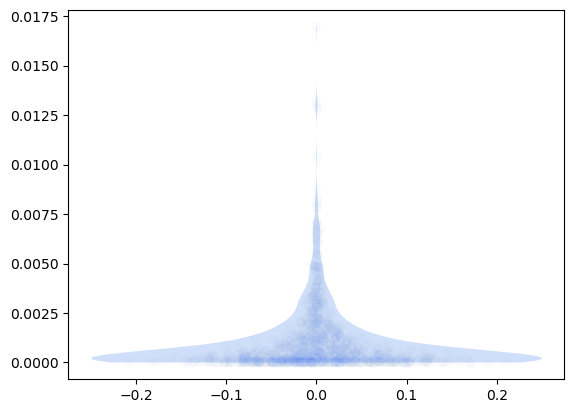

In [303]:
from Analysis.utils import violin_scatter

violin_scatter(
    c_**2,
    pos=[0],
)

# Fast-Fast heatmap

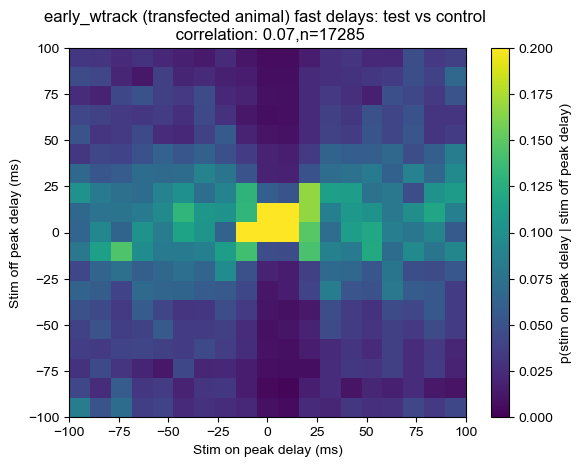

In [37]:
animal = "transfected"
# animal = "control"


min_coincidients = 50
# test_delays = results[animal]["test"].peak_delay_fast
# control_delays = results[animal]["control"].peak_delay_fast

# plt.scatter(test_delays, control_delays, alpha=0.2)
fig = plt.figure()
merged_df = pd.merge(
    results[animal]["test"],
    results[animal]["control"],
    how="inner",
    on=["s_id_1", "s_id_2"],
)
merged_df = merged_df[
    np.logical_and(
        merged_df.n_coincidients_fast_x > min_coincidients,
        merged_df.n_coincidients_fast_y > min_coincidients,
    )
]

# test_delays = merged_df.peak_delay_fast_x
# control_delays = merged_df.peak_delay_fast_y

test_df = merged_df.copy()
test_df = test_df.rename(
    columns={
        "cross_corr_fast_x": "cross_corr_fast",
    }
)
test_delays = np.array([get_max_fast_peak_delay(row) for _, row in test_df.iterrows()])


control_df = merged_df.copy()
control_df = control_df.rename(
    columns={
        "cross_corr_fast_y": "cross_corr_fast",
    }
)
control_delays = np.array(
    [get_max_fast_peak_delay(row) for _, row in control_df.iterrows()]
)

# plt.scatter(test_delays, control_delays, alpha=0.2)
H = np.histogram2d(
    control_delays,
    test_delays,
    bins=(np.arange(-100, 100, 10), np.arange(-100, 100, 10)),
)[0]
H = H / H.sum(axis=1)[:, None]  #
# H = H/H.sum()

plt.imshow(
    H.T,
    origin="lower",
    extent=(-100, 100, -100, 100),
    # cmap="Blues",
    aspect="auto",
    clim=(0, 0.2),
)
plt.colorbar(label="p(stim on peak delay | stim off peak delay)")
# plt.clim(0.1)
#
np.corrcoef(test_delays, control_delays)[0, 1]

plt.title(
    f"{track} ({animal} animal) fast delays: test vs control \n correlation: {np.corrcoef(test_delays, control_delays)[0, 1]:.2f},n={len(test_delays)}"
)

plt.xlabel("Stim on peak delay (ms)")
plt.ylabel("Stim off peak delay (ms)")

if animal == "control":
    fig.savefig(
        f"/home/sambray/Documents/MS_analysis_samsplaying/Figures202507/wtrack_control_fast_peak_delay_test_vs_control.svg"
    )
elif animal == "transfected":
    fig.savefig(
        f"/home/sambray/Documents/MS_analysis_samsplaying/Figures202507/wtrack_transfected_fast_peak_delay_test_vs_control.svg"
    )

# fig.savefig(
#     f"/home/sambray/Documents/MS_analysis_samsplaying/Figures_20250501/lineartrack_{animal}_fast_peak_delay_test_vs_control.svg"
# )
# fig.savefig("/home/sambray/Documents/MS_analysis_samsplaying/Figures_20250501/tewt.svg")

# fig.savefig(
#     f"/home/sambray/Documents/MS_analysis_samsplaying/Figures_20250501/wtrack_transfecred_fast_peak_delay_test_vs_control.svg"
# )
# fig.savefig(
#     f"/home/sambray/Documents/MS_analysis_samsplaying/Figures_20250501/wtrack_control_fast_peak_delay_test_vs_control.svg"
# )

# plt.hist2d(
#     test_delays,
#     control_delays,
#     bins=(np.arange(-100, 100, 10), np.arange(-100, 100, 10)),
#     cmap="Blues",
#     cmin=1,
# )

In [19]:
n_boot = 10000

animal_groups = {
    "control": [
        "Yoshi",
        "Wallie",
        # "Bilbo",
        # "Olive",
    ],
    "targeted": [
        "Winnie",
        # "Frodo",
        "Totoro",
    ],
}


def test_diff_of_bootstrap_dist(dist1, dist2):
    diff = np.subtract.outer(dist1, dist2)
    diff = np.ravel(diff)
    # standarize the sign of the difference
    if np.mean(diff) < 0:
        diff = -diff
    p_val = np.sum(diff < 0) / diff.size
    return p_val

In [20]:
from tqdm import tqdm

bootstrap_results = {}

for group, animals in animal_groups.items():
    # bootstrap_results[group] = {}

    temp_results = {}
    for animal in animals:
        merged_df = pd.merge(
            results[animal]["test"],
            results[animal]["control"],
            how="inner",
            on=["s_id_1", "s_id_2"],
        )

        test_df = merged_df.copy()
        test_df = test_df.rename(
            columns={
                "cross_corr_fast_x": "cross_corr_fast",
            }
        )
        test_delays = np.array(
            [get_max_fast_peak_delay(row) for _, row in test_df.iterrows()]
        )

        control_df = merged_df.copy()
        control_df = control_df.rename(
            columns={
                "cross_corr_fast_y": "cross_corr_fast",
            }
        )
        control_delays = np.array(
            [get_max_fast_peak_delay(row) for _, row in control_df.iterrows()]
        )

        df = pd.DataFrame(
            {
                "control_delays": control_delays,
                "test_delays": test_delays,
            }
        )

        temp_results[animal] = df

    c_ = []
    for _ in tqdm(range(n_boot), desc=f"Bootstrapping {group} "):
        animal_samples = np.random.choice(animals, len(animals), replace=True)
        control_val = []
        test_val = []
        for animal in animal_samples:
            df = temp_results[animal]
            pair_samples = np.random.choice(len(df), len(df), replace=True)
            control_val.extend(df.control_delays.values[pair_samples])
            test_val.extend(df.test_delays.values[pair_samples])
        corr = np.corrcoef(control_val, test_val)[0, 1]
        c_.append(corr)
    c_ = np.array(c_)
    bootstrap_results[group] = c_

Bootstrapping targeted : 100%|██████████| 10000/10000 [00:42<00:00, 235.44it/s]


0.0008152

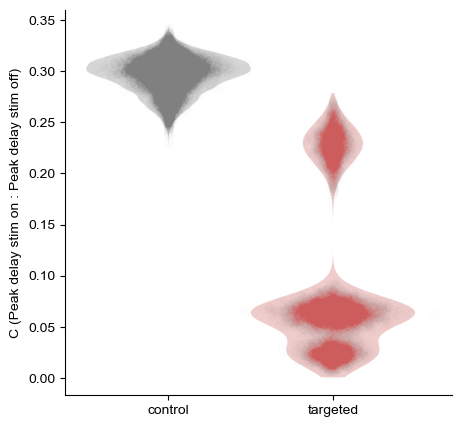

In [ ]:
from Analysis.utils import violin_scatter

fig = plt.figure(figsize=(5, 5))
for animal in bootstrap_results:
    scores = bootstrap_results[animal]
    # color = animal_style.loc[animal, "color"]
    xloc = 0 if animal == "control" else 0.5
    color = (
        animal_style.loc["control", "color"]
        if animal == "control"
        else animal_style.loc["transfected", "color"]
    )
    violin_scatter(scores, pos=[xloc], color=color)
    # ticks.append(xloc)
    # labels.append(animal)
plt.xticks([0, 0.5], ["control", "targeted"], rotation=0)
ax = fig.gca()
ax.spines[["top", "right"]].set_visible(False)
ax.set_ylabel("C (Peak delay stim on : Peak delay stim off)")

# ybar = 0.35
# plt.plot(
#     [-0.1, 0.6],
#     [ybar, ybar],
#     color="k",
#     lw=1,
# )
# plt.text(
#     0.25,
#     ybar + 0.01,
#     "* p < 0.05",
#     ha="center",
#     va="center",
#     fontsize=10,
#     color="k",
# )

# fig.savefig(
#     "/home/sambray/Documents/MS_analysis_samsplaying/Figures_20250501/lineartrack_fast_fast_bootstrap_correlation_coefficients_Excludeanimals.svg"
# )

fig.savefig(
    "/home/sambray/Documents/MS_analysis_samsplaying/Figures_202507/wtrack_fast_fast_bootstrap_correlation_coefficients_Excludeanimals.svg"
)

test_diff_of_bootstrap_dist(bootstrap_results["control"], bootstrap_results["targeted"])

0.0008152

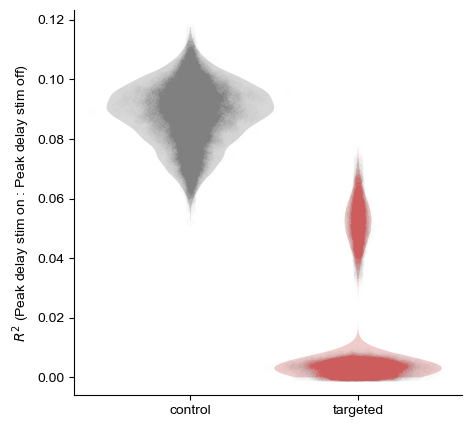

In [25]:
from Analysis.utils import violin_scatter

fig = plt.figure(figsize=(5, 5))
for animal in bootstrap_results:
    scores = bootstrap_results[animal] ** 2
    # color = animal_style.loc[animal, "color"]
    xloc = 0 if animal == "control" else 0.5
    color = (
        animal_style.loc["control", "color"]
        if animal == "control"
        else animal_style.loc["transfected", "color"]
    )
    violin_scatter(scores, pos=[xloc], color=color)
    # ticks.append(xloc)
    # labels.append(animal)
plt.xticks([0, 0.5], ["control", "targeted"], rotation=0)
ax = fig.gca()
ax.spines[["top", "right"]].set_visible(False)
ax.set_ylabel("$R^2$ (Peak delay stim on : Peak delay stim off)")

# ybar = 0.35
# plt.plot(
#     [-0.1, 0.6],
#     [ybar, ybar],
#     color="k",
#     lw=1,
# )
# plt.text(
#     0.25,
#     ybar + 0.01,
#     "* p < 0.05",
#     ha="center",
#     va="center",
#     fontsize=10,
#     color="k",
# )

# fig.savefig(
#     "/home/sambray/Documents/MS_analysis_samsplaying/Figures_20250501/lineartrack_fast_fast_bootstrap_correlation_coefficients_Excludeanimals.svg"
# )

fig.savefig(
    "/home/sambray/Documents/MS_analysis_samsplaying/Figures202507/wtrack_fast_fast_heirarchical_bootstrap_R2_Excludeanimals.svg"
)

test_diff_of_bootstrap_dist(bootstrap_results["control"], bootstrap_results["targeted"])

## Non heirachy bootstrap

In [39]:
from tqdm import tqdm

bootstrap_results = {}
n_boot = 10000


for animal in ["control", "transfected"]:
    df = results[animal]["test"]
    merged_df = pd.merge(
        results[animal]["test"],
        results[animal]["control"],
        how="inner",
        on=["s_id_1", "s_id_2"],
    )

    test_df = merged_df.copy()
    test_df = test_df.rename(
        columns={
            "cross_corr_fast_x": "cross_corr_fast",
        }
    )
    test_delays = np.array(
        [get_max_fast_peak_delay(row) for _, row in test_df.iterrows()]
    )

    control_df = merged_df.copy()
    control_df = control_df.rename(
        columns={
            "cross_corr_fast_y": "cross_corr_fast",
        }
    )
    control_delays = np.array(
        [get_max_fast_peak_delay(row) for _, row in control_df.iterrows()]
    )

    df = pd.DataFrame(
        {
            "control_delays": control_delays,
            "test_delays": test_delays,
        }
    )

    c_ = []
    for _ in tqdm(range(n_boot), desc=f"Bootstrapping {animal} "):
        pair_samples = np.random.choice(len(df), len(df), replace=True)
        control_val = df.control_delays.values[pair_samples]
        test_val = df.test_delays.values[pair_samples]
        corr = np.corrcoef(control_val, test_val)[0, 1]
        c_.append(corr)
    c_ = np.array(c_)
    bootstrap_results[animal] = c_

Bootstrapping transfected : 100%|██████████| 10000/10000 [00:06<00:00, 1444.51it/s]


In [ ]:
def test_diff_of_bootstrap_dist(dist1, dist2):
    diff = np.subtract.outer(dist1, dist2)
    diff = np.ravel(diff)
    # standarize the sign of the difference
    if np.mean(diff) < 0:
        diff = -diff
    p_val = np.sum(diff < 0) / diff.size

    return p_val

0.0


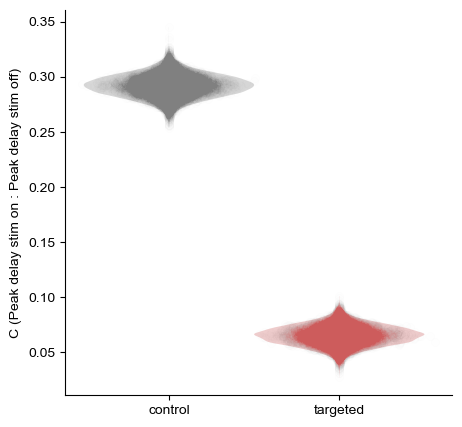

In [41]:
from Analysis.utils import violin_scatter

fig = plt.figure(figsize=(5, 5))
for animal in bootstrap_results:
    scores = bootstrap_results[animal]
    # color = animal_style.loc[animal, "color"]
    xloc = 0 if animal == "control" else 0.5
    color = (
        animal_style.loc["control", "color"]
        if animal == "control"
        else animal_style.loc["transfected", "color"]
    )
    violin_scatter(scores, pos=[xloc], color=color)
    # ticks.append(xloc)
    # labels.append(animal)
plt.xticks([0, 0.5], ["control", "targeted"], rotation=0)
ax = fig.gca()
ax.spines[["top", "right"]].set_visible(False)
ax.set_ylabel("C (Peak delay stim on : Peak delay stim off)")

# ybar = 0.35
# plt.plot(
#     [-0.1, 0.6],
#     [ybar, ybar],
#     color="k",
#     lw=1,
# )
# plt.text(
#     0.25,
#     ybar + 0.01,
#     "* p < 0.05",
#     ha="center",
#     va="center",
#     fontsize=10,
#     color="k",
# )

# fig.savefig(
#     "/home/sambray/Documents/MS_analysis_samsplaying/Figures_20250501/lineartrack_fast_fast_bootstrap_correlation_coefficients_Excludeanimals.svg"
# )
fig.savefig(
    "/home/sambray/Documents/MS_analysis_samsplaying/Figures202507/wtrack_fast_fast_NonHierarchical_bootstrap_correlation_coefficients.svg"
)

pval = test_diff_of_bootstrap_dist(
    bootstrap_results["control"], bootstrap_results["transfected"]
)
print(pval)

In [ ]:
pval > 0

False

0.0

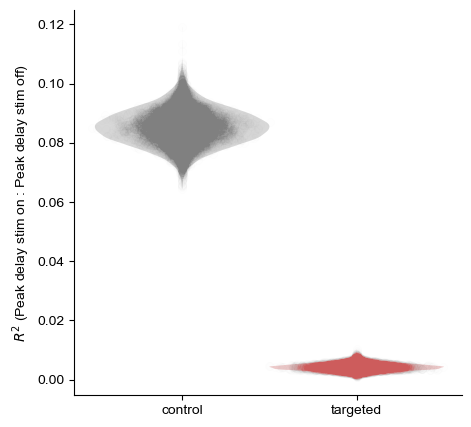

In [ ]:
from Analysis.utils import violin_scatter

fig = plt.figure(figsize=(5, 5))
for animal in bootstrap_results:
    scores = bootstrap_results[animal] ** 2
    # color = animal_style.loc[animal, "color"]
    xloc = 0 if animal == "control" else 0.5
    color = (
        animal_style.loc["control", "color"]
        if animal == "control"
        else animal_style.loc["transfected", "color"]
    )
    violin_scatter(scores, pos=[xloc], color=color)
    # ticks.append(xloc)
    # labels.append(animal)
plt.xticks([0, 0.5], ["control", "targeted"], rotation=0)
ax = fig.gca()
ax.spines[["top", "right"]].set_visible(False)
ax.set_ylabel("$R^2$ (Peak delay stim on : Peak delay stim off)")

# ybar = 0.35
# plt.plot(
#     [-0.1, 0.6],
#     [ybar, ybar],
#     color="k",
#     lw=1,
# )
# plt.text(
#     0.25,
#     ybar + 0.01,
#     "* p < 0.05",
#     ha="center",
#     va="center",
#     fontsize=10,
#     color="k",
# )

# fig.savefig(
#     "/home/sambray/Documents/MS_analysis_samsplaying/Figures_20250501/lineartrack_fast_fast_bootstrap_correlation_coefficients_Excludeanimals.svg"
# )
fig.savefig(
    "/home/sambray/Documents/MS_analysis_samsplaying/Figures202507/wtrack_fast_fast_NonHierarchical_bootstrap_R2.svg"
)

test_diff_of_bootstrap_dist(
    bootstrap_results["control"], bootstrap_results["transfected"]
)

# Old Quantifications

### Ridge tracing

(0.0, 20.0)

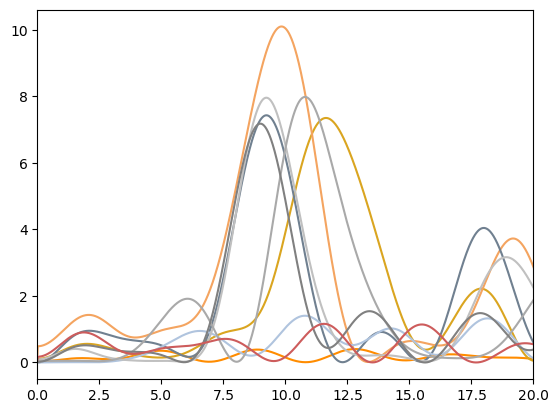

In [218]:
for animal in heatmap_results:
    H = heatmap_results[animal]["stim on"]
    ridge = np.argmax(H, axis=1)
    # plt.plot(bx[1:], ridge)

    f, p, _ = power_spectrum(ridge, ridge.size, 1000 / slow_bin_size)
    plt.plot(
        f,
        p,
        color=animal_style.loc[
            animal,
            "color",
        ],
    )


plt.xlim(0, 20)

<BarContainer object of 2 artists>

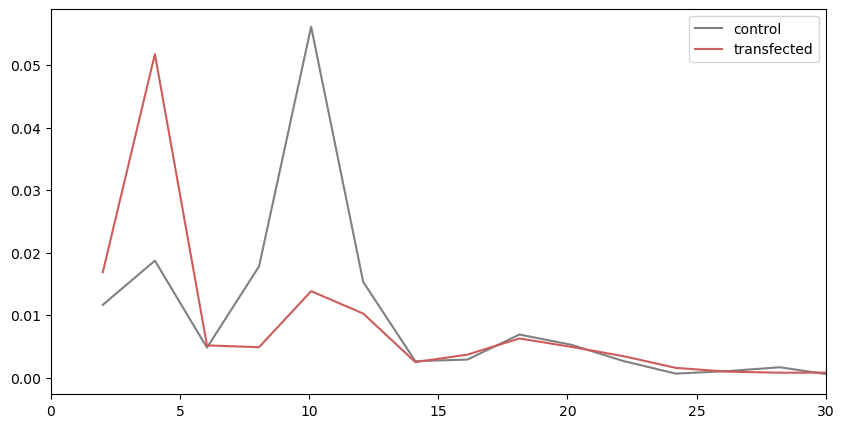

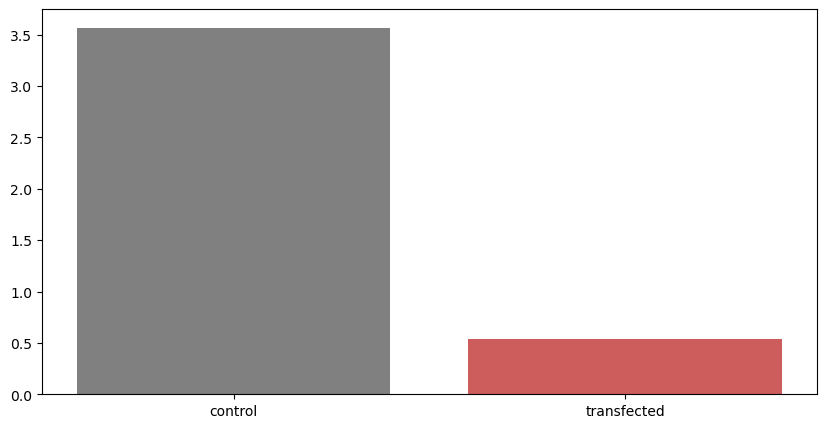

In [219]:
fig = plt.figure(figsize=(10, 5))


def spectrum_score(f, p):

    ind_pos = np.logical_and(f > 8, f < 12)
    ind_neg = np.logical_or(
        np.logical_and(f > 12, f < 15), np.logical_and(f > 4, f < 8)
    )
    pos_power = p[ind_pos].mean()
    neg_power = p[ind_neg].mean()
    return pos_power / neg_power


scores = {}
for animal in results.keys():
    if animal not in ["transfected", "control"]:
        continue

    x = heatmap_results[animal]["stim on"]
    power_spectra = np.abs(np.fft.fft(x, axis=0)) ** 2
    freq = np.fft.fftfreq(
        x.shape[0], d=slow_bin_size / 1000
    )  # Assuming sampling rate of 1000 Hz
    f = freq
    ind = f > 0
    # f = np.log10(f)
    plt.plot(
        f[ind],
        np.mean(power_spectra, axis=1)[ind],
        color=animal_style.loc[animal].color,
        label=animal,
    )
    scores[animal] = spectrum_score(f[ind], np.mean(power_spectra, axis=1)[ind])

plt.xlim(0, 30)
plt.legend(loc=1)

fig2 = plt.figure(figsize=(10, 5))
plt.bar(
    list(scores.keys()),
    list(scores.values()),
    color=[animal_style.loc[x].color for x in scores.keys()],
)

Text(0, 0.5, 'Ratio of power in 8-12 Hz to avg in (4-8 Hz and 12-15 Hz)')

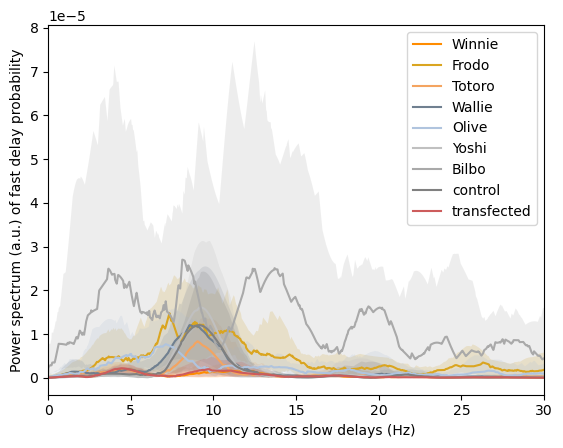

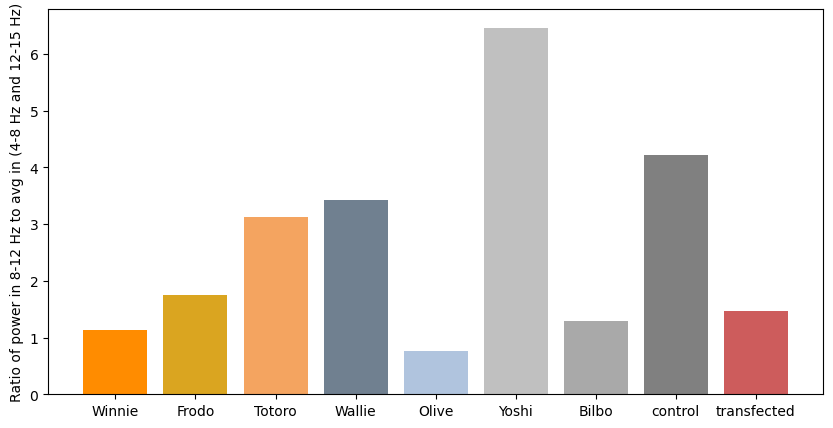

In [ ]:
from Analysis.lfp_analysis import power_spectrum

scores = {}
for animal in results.keys():
    # if animal  not in ["transfected", "control"]:
    #     continue

    x = heatmap_results[animal]["stim on"]
    p_all = []
    for xx in x.T:
        f, p, _ = power_spectrum(xx, xx.size, 1000 / slow_bin_size)
        p_all.append(p)

    plt.plot(
        f, np.median(p_all, axis=0), color=animal_style.loc[animal].color, label=animal
    )
    plt.fill_between(
        f,
        np.percentile(p_all, 25, axis=0),
        np.percentile(p_all, 75, axis=0),
        facecolor=animal_style.loc[animal].color,
        alpha=0.2,
    )

    # scores[animal] = spectrum_score(f, np.mean(p_all, axis=0))
    scores[animal] = [spectrum_score(f, p) for p in p_all]

plt.xlim(0, 30)
plt.legend(loc=1)
plt.xlabel("Frequency across slow delays (Hz)")
plt.ylabel("Power spectrum (a.u.) of fast delay probability")

fig2 = plt.figure(figsize=(10, 5))
plt.bar(
    list(scores.keys()),
    # list(scores.values()),
    [np.mean(s) for s in scores.values()],
    color=[animal_style.loc[x].color for x in scores.keys()],
)
# for i, (animal, s) in enumerate(scores.items()):
# violin_scatter(s, pos=[i], color=animal_style.loc[animal, "color"])
plt.xticks(np.arange(len(scores)), scores.keys())
plt.ylabel("Ratio of power in 8-12 Hz to avg in (4-8 Hz and 12-15 Hz)")

(0.0, 3e-05)

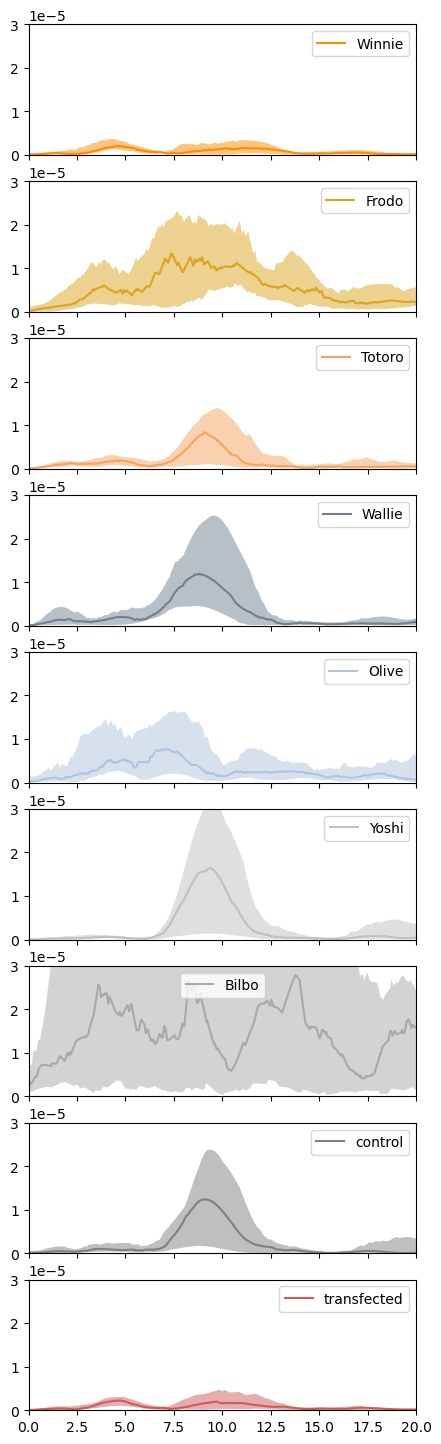

In [ ]:
fig, ax = plt.subplots(len(results), sharex=True, sharey=True, figsize=(5, 18))

from Analysis.lfp_analysis import power_spectrum

scores = {}
for i, animal in enumerate(results.keys()):
    # if animal  not in ["transfected", "control"]:
    #     continue

    x = heatmap_results[animal]["stim on"]
    p_all = []
    for xx in x.T:
        f, p, _ = power_spectrum(xx, xx.size, 1000 / slow_bin_size)
        p_all.append(p)

    ax[i].plot(
        f, np.median(p_all, axis=0), color=animal_style.loc[animal].color, label=animal
    )
    std = np.std(p_all, axis=0)
    ax[i].fill_between(
        f,
        np.percentile(p_all, 25, axis=0),
        np.percentile(p_all, 75, axis=0),
        # np.mean(p_all, axis=0) - std,
        # np.mean(p_all, axis=0) + std,
        facecolor=animal_style.loc[animal].color,
        alpha=0.5,
    )
    ax[i].legend()
plt.xlim(0, 20)
plt.ylim(0, 3e-5)

In [ ]:
from scipy.signal import correlate2d

x = ref_H
autocorr = correlate2d(x, x, mode="full", boundary="symm")

In [102]:
from numpy.fft import fft2, fftshift

fft_result = fftshift(fft2(autocorr))
magnitude_spectrum = np.abs(fft_result)

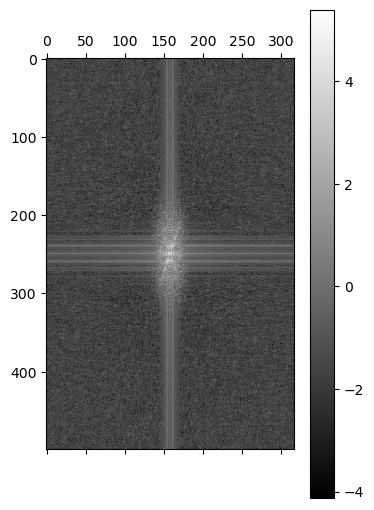

In [ ]:
plt.matshow(
    np.log10(magnitude_spectrum),
    cmap="gray",
)
plt.colorbar()

### Distribution entropy vs. slow delay

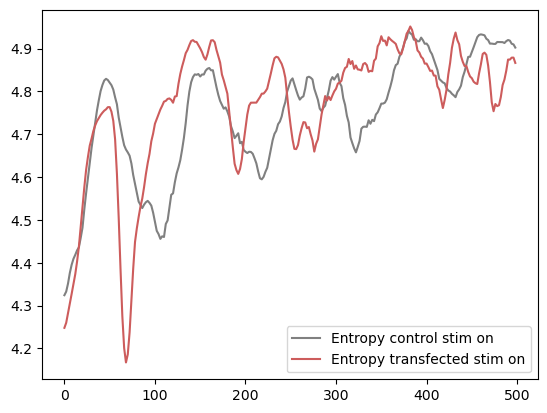

In [ ]:
from scipy.stats import entropy
from Style.style_guide import animal_style

H.shape

bx.shape, entropy(H, axis=1).shape
for animal in heatmap_results:
    if animal not in ["control", "transfected"]:
        continue

    for cond in heatmap_results[animal]:
        if cond == "stim off":
            continue
        H = heatmap_results[animal][cond]
        fast_dist = fast_distribution[animal][cond]
        slow_dist = slow_distribution[animal][cond]
        val = (entropy(H, axis=1) - entropy(fast_dist)) / entropy(fast_dist)
        val = entropy(H, axis=1)
        plt.plot(
            bx[:-1],
            val,
            label=f"Entropy {animal} {cond}",
            color=animal_style.loc[animal, "color"],
        )

plt.legend()

### KL divergence from reference

Text(0, 0.5, 'KL divergence of p(fast peak delay | slow peak delay) from control stim off')

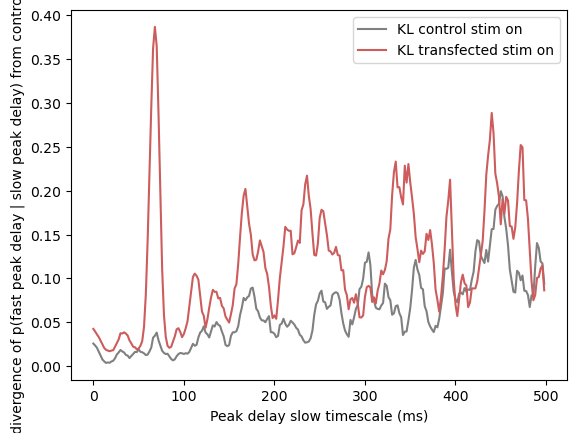

In [ ]:
sh = 0.0

ref_H = heatmap_results["control"]["stim off"].copy() + sh
# ref_H = ref_H/ ref_H.sum(axis=1)[:, None]  # Normalize reference histogram

# fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10, 8), sharex=True, sharey=True)
for a, animal in zip(ax, results.keys()):
    # if animal in ["control", "transfected", "Olive","Bilbo","Frodo"]:
    #     continue
    if animal not in ["control", "transfected"]:
        continue

    for a_i, (cond, H) in zip(a, heatmap_results[animal].items()):
        if cond == "stim off":
            continue

        test_H = H.copy() + sh
        # test_H = test_H / test_H.sum(axis=1)[:, None]  #

        kl = np.zeros(H.shape[0])
        for i in range(H.shape[0]):
            kl[i] = np.nansum(test_H[i] * np.log(test_H[i] / ref_H[i, :]))
            # kl[i] = np.nansum(ref_H[i, :] * np.log(ref_H[i, :] / test_H[i]))
        plt.plot(
            bx[:-1],
            kl,
            label=f"KL {animal} {cond}",
            color=animal_style.loc[animal, "color"],
        )

        # plt.set_title(f"{animal} {cond}")
plt.legend()
plt.xlabel("Peak delay slow timescale (ms)")
plt.ylabel(
    "KL divergence of p(fast peak delay | slow peak delay) from control stim off"
)

In [36]:
H.shape, fast_dist.shape

((31, 26), (26,))

### Mutual information

Text(0.5, 1.0, 'Mutual Information between Slow and Fast Peak Delays')

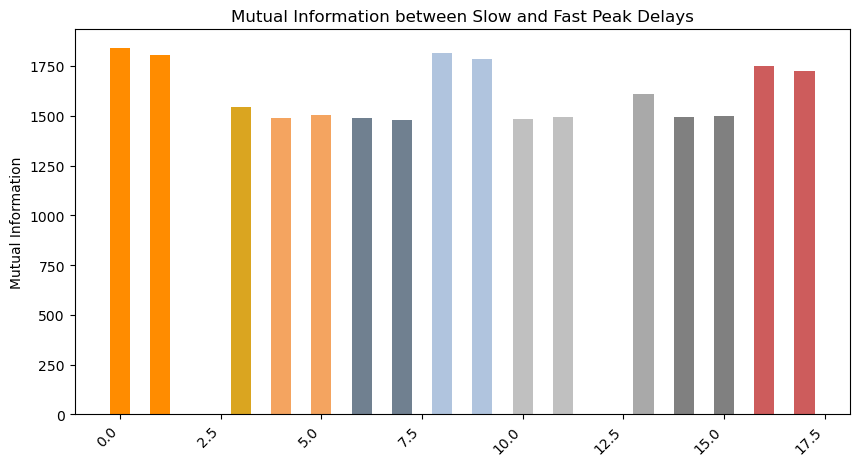

In [89]:
def discrete_mutual_information(p_xy, p_x, p_y, log_base=np.e):
    # Calculate the discrete mutual information
    mi = np.nansum(
        p_xy * np.log(p_xy / (p_x[:, None] * p_y[None, :])) / np.log(log_base)
    )
    return mi


labels = []
mi_values = []
for animal in heatmap_results:
    for cond in heatmap_results[animal]:
        H = heatmap_results[animal][cond]
        fast_dist = fast_distribution[animal][cond]
        slow_dist = slow_distribution[animal][cond]
        mi = discrete_mutual_information(H, slow_dist, fast_dist)
        # plt.plot(bx[:-1], mi * np.ones_like(bx[:-1]), label=f"MI {animal} {cond}", color=animal_style.loc[animal, "color"])
        labels.append(f"{animal} {cond}")
        mi_values.append(mi)
plt.figure(figsize=(10, 5))
plt.bar(
    np.arange(len(mi_values)),
    mi_values,
    color=[
        animal_style.loc[animal, "color"]
        for animal in heatmap_results.keys()
        for cond in heatmap_results[animal].keys()
    ],
    width=0.5,
)
plt.xticks(rotation=45, ha="right")
plt.ylabel("Mutual Information")
plt.title("Mutual Information between Slow and Fast Peak Delays")

In [ ]:
for l, v in zip(labels, mi_values):
    print(f"{l}: {v:.4f}")

transfected stim off: 157.5724
transfected stim on: 152.4203
control stim off: 123.1601
control stim on: 122.6668


### Corelational difference

In [90]:
def smooth_heatmap(H, kernel_size=1):
    from scipy.ndimage import gaussian_filter

    H = H.copy()
    H += 1e-10  # Avoid division by zero
    return gaussian_filter(H, sigma=kernel_size)

[[-0.01149001 -0.18073617 -0.35761278 ... -0.19323155 -0.20971572
  -0.2915478 ]
 [-0.30445341 -0.0915595  -0.33582404 ... -0.11048742 -0.24769701
  -0.08543395]
 [-0.08764739 -0.09332452 -0.37207812 ...  0.06420688 -0.07916602
  -0.12609569]
 ...
 [ 0.70450814  0.70450814  0.70450814 ...  1.51742149  1.40347814
   1.35772065]
 [ 0.73304133  0.73304133  1.03407132 ...  1.03407132  1.73304133
   1.63613132]
 [ 0.72516555  0.72516555  0.72516555 ...  1.42413556  1.36198765
   1.02619555]]
[[-0.41787304 -0.48551637 -0.54993152 ... -0.49471307 -0.50330323
  -0.62499853]
 [-0.52648036 -0.31110811 -0.55879268 ... -0.48876875 -0.68451951
  -0.60074251]
 [-0.42351079 -0.29716429 -0.47217826 ... -0.3411595  -0.48609277
  -0.51164688]
 ...
 [ 0.21696038  0.21696038  0.51799037 ...  0.21696038  0.21696038
  -0.08406962]
 [ 0.53500655  0.23397656  0.71109781 ... -0.54417469  0.23397656
   0.23397656]
 [ 0.55978613  0.95772614  0.95772614 ...  0.4348474  -0.21836512
  -0.34330385]]
[[ 0.37980086  0

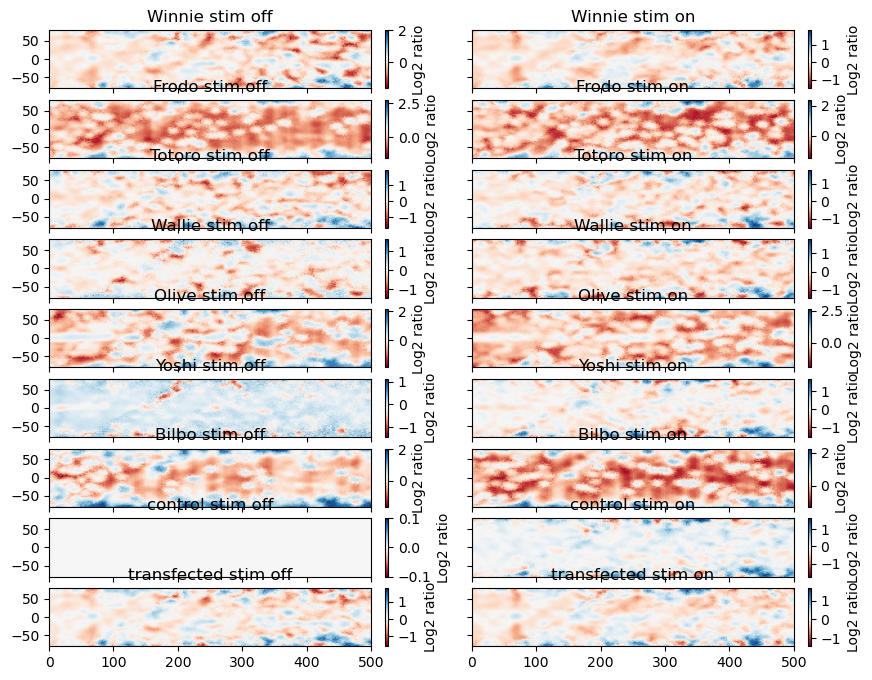

In [ ]:
kernel = 10
ref_H = heatmap_results["control"]["stim off"]

fig, ax = plt.subplots(
    nrows=len(results), ncols=2, figsize=(10, 8), sharex=True, sharey=True
)
for a, animal in zip(ax, results.keys()):
    for a_i, (cond, H) in zip(a, heatmap_results[animal].items()):

        val = smooth_heatmap(heatmap_results[animal][cond], kernel)
        ref_val = smooth_heatmap(ref_H, kernel)

        val = np.log10(heatmap_results[animal][cond] / ref_H)

        # var_val = val-val.mean()
        # var_ref = ref_val-ref_val.mean()
        # val = var_val * var_ref

        # val = np.log10(val)

        print(val)
        c_scale = 2
        a_i.imshow(
            val.T,
            cmap="RdBu",
            aspect="auto",
            origin="lower",
            extent=(bx[0], bx[-1], by[0], by[-1]),
            # clim=(-c_scale, c_scale),
        )
        # plt.colorbar(label='Log ratio of stim on to stim off')
        a_i.set_title(f"{animal} {cond}")
        fig.colorbar(
            a_i.images[-1],
            ax=a_i,
            orientation="vertical",
            fraction=0.046,
            pad=0.04,
            label="Log2 ratio",
        )

### change in relative values

[[-0.59982812 -0.59464458 -0.58428655 ...  0.42357536  0.43259283
   0.43701998]
 [-0.59454331 -0.58939808 -0.57911853 ...  0.4209063   0.42992943
   0.43435953]
 [-0.58396668 -0.57889653 -0.5687709  ...  0.41552934  0.424561
   0.42899558]
 ...
 [        nan         nan         nan ...         nan         nan
          nan]
 [        nan         nan         nan ...         nan         nan
          nan]
 [        nan         nan         nan ...         nan         nan
          nan]]
[[-0.86638545 -0.86124417 -0.85097721 ... -0.21190141 -0.20812437
  -0.20623364]
 [-0.85678431 -0.85173416 -0.84164808 ... -0.20737543 -0.2035663
  -0.20166049]
 [-0.83766997 -0.83279972 -0.82307066 ... -0.19842232 -0.19454601
  -0.19260842]
 ...
 [        nan         nan         nan ...         nan         nan
          nan]
 [        nan         nan         nan ...         nan         nan
          nan]
 [        nan         nan         nan ...         nan         nan
          nan]]
[[0. 0. 0. ... 0. 0

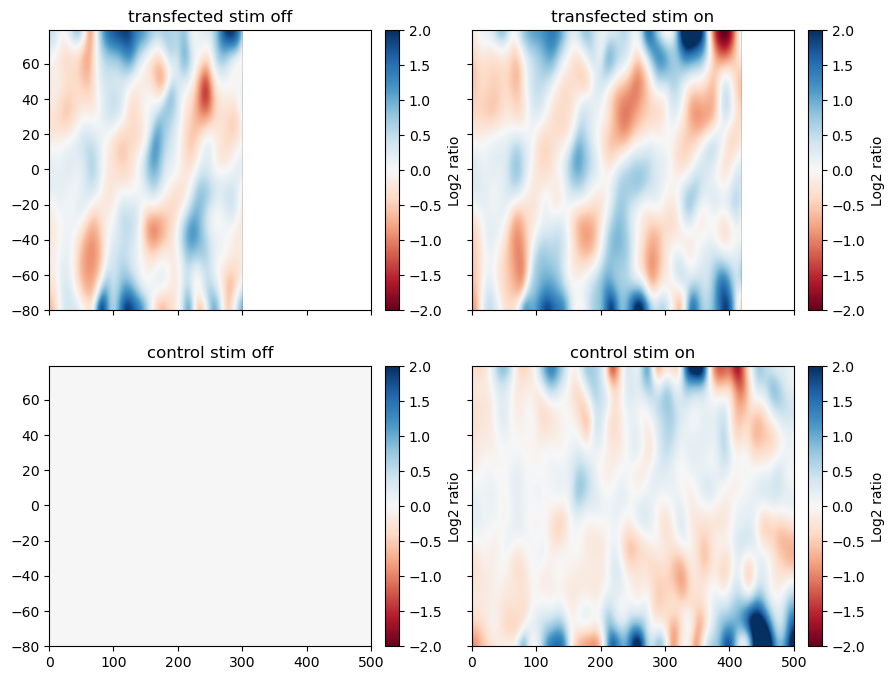

In [ ]:
kernel = 10
ref_H = heatmap_results["control"]["stim off"]

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10, 8), sharex=True, sharey=True)
for a, animal in zip(ax, results.keys()):
    for a_i, (cond, H) in zip(a, heatmap_results[animal].items()):

        val = smooth_heatmap(heatmap_results[animal][cond], kernel)

        val = val / smooth_heatmap(ref_H, kernel)
        val = np.log2(val)
        print(val)
        c_scale = 2
        a_i.imshow(
            val.T,
            cmap="RdBu",
            aspect="auto",
            origin="lower",
            extent=(bx[0], bx[-1], by[0], by[-1]),
            clim=(-c_scale, c_scale),
        )
        # plt.colorbar(label='Log ratio of stim on to stim off')
        a_i.set_title(f"{animal} {cond}")
        fig.colorbar(
            a_i.images[-1],
            ax=a_i,
            orientation="vertical",
            fraction=0.046,
            pad=0.04,
            label="Log2 ratio",
        )

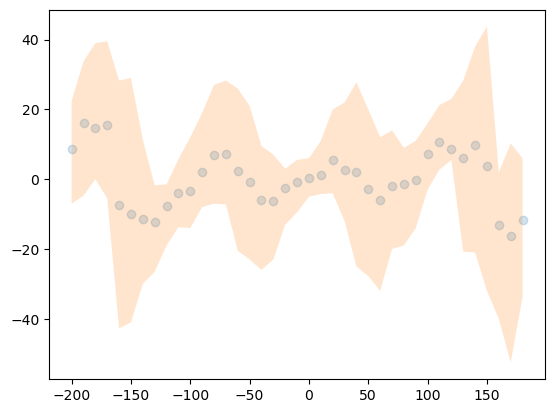

In [ ]:
import numpy as np


df = merged_test_df

fast = df.peak_delay_fast.values
slow = df.peak_delay_slow.values

bins = np.arange(-200, 200, 10)
yy = np.zeros(len(bins) - 1)
lo = np.zeros(len(bins) - 1)
hi = np.zeros(len(bins) - 1)
for i in range(len(bins) - 1):
    mask = (slow >= bins[i]) & (slow < bins[i + 1])
    if mask.sum() == 0:
        continue
    yy[i] = fast[mask].mean()
    lo[i] = np.percentile(fast[mask], 25)
    hi[i] = np.percentile(fast[mask], 75)

plt.scatter(bins[:-1], yy, alpha=0.2)
plt.fill_between(bins[:-1], lo, hi, alpha=0.2)

## distribution cross product version

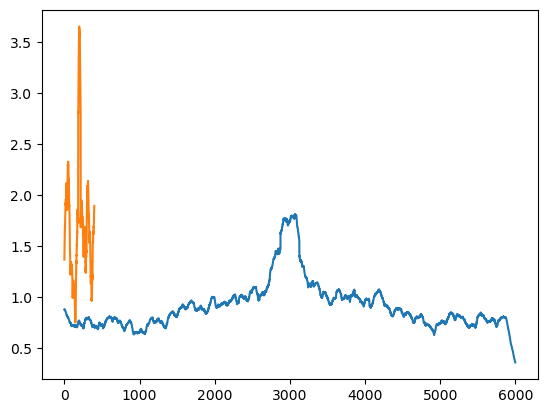

In [ ]:
results

animal = "Winnie"
control_df = results[animal]["control"]
test_df = results[animal]["test"]

merged_df = test_df

plt.plot(merged_df.cross_corr_slow.values[0])
plt.plot(merged_df.cross_corr_fast.values[0])

In [73]:
merged_df

s_id_1  \
0      28d41724-54be-d56e-9c10-160d7c53cd3e_0   
1      28d41724-54be-d56e-9c10-160d7c53cd3e_0   
2      28d41724-54be-d56e-9c10-160d7c53cd3e_0   
3      28d41724-54be-d56e-9c10-160d7c53cd3e_0   
4      28d41724-54be-d56e-9c10-160d7c53cd3e_0   
...                                       ...   
31898  4b0a5f47-8fc7-b3e3-5b78-87fb404f7934_6   
31899  4b0a5f47-8fc7-b3e3-5b78-87fb404f7934_6   
31900  4b0a5f47-8fc7-b3e3-5b78-87fb404f7934_6   
31901  4b0a5f47-8fc7-b3e3-5b78-87fb404f7934_6   
31902  4b0a5f47-8fc7-b3e3-5b78-87fb404f7934_6   

                                        s_id_2  field_loc_1_slow  \
0       16e76a3a-8b9c-47e5-f989-268fd883f527_1        102.176318   
1       16e76a3a-8b9c-47e5-f989-268fd883f527_2        102.176318   
2       16e76a3a-8b9c-47e5-f989-268fd883f527_3        102.176318   
3       16e76a3a-8b9c-47e5-f989-268fd883f527_5        102.176318   
4       16e76a3a-8b9c-47e5-f989-268fd883f527_6        102.176318   
...                                        ...               ...   
31898  3fb6683e-9011-1e15-5c45-613152554557_10        102.176318   
31899  3fb6683e-9011-1e15-5c45-613152554557_13        102.176318   
31900  3fb6683e-9011-1e15-5c45-613152554557_15        102.176318   
31901   4b0a5f47-8fc7-b3e3-5b78-87fb404f7934_4        102.176318   
31902   4b0a5f47-8fc7-b3e3-5b78-87fb404f7934_5        102.176318   

       field_loc_2_slow  distance_slow  \
0            102.176318              0   
1            102.176318              0   
2            102.176318              0   
3            102.176318              0   
4            102.176318              0   
...                 ...            ...   
31898        102.176318              0   
31899        102.176318              0   
31900        102.176318              0   
31901        102.176318              0   
31902        102.176318              0   

                                         cross_corr_slow  peak_delay_slow  \
0      [0.8792326130801925, 0.878855088945861, 0.8784...               69   
1      [0.35764694344988546, 0.3620412505046985, 0.36...             -190   
2      [1.0485978852411952, 1.0394451910277005, 1.030...               -1   
3      [0.03513260203389736, 0.03527525603429052, 0.0...                0   
4      [0.14075418640930296, 0.1413228877156195, 0.14...              -94   
...                                                  ...              ...   
31898  [1.5102466977786693, 1.5051941516530902, 1.497...              -65   
31899  [0.3538665578247544, 0.354926033183901, 0.3559...              -66   
31900  [0.42834843424168817, 0.43518428899381045, 0.4...              -65   
31901  [0.7131608192762099, 0.7177474962407279, 0.716...               10   
31902  [0.17820145879230315, 0.1817023147751055, 0.18...                7   

       n_coincidients_slow  field_loc_1_fast  field_loc_2_fast  distance_fast  \
0                     3200        102.176318        102.176318              0   
1                     3517        102.176318        102.176318              0   
2                     2038        102.176318        102.176318              0   
3                      953        102.176318        102.176318              0   
4                     1341        102.176318        102.176318              0   
...                    ...               ...               ...            ...   
31898                 6561        102.176318        102.176318              0   
31899                 4669        102.176318        102.176318              0   
31900                 4587        102.176318        102.176318              0   
31901                 2230        102.176318        102.176318              0   
31902                 2293        102.176318        102.176318              0   

                                         cross_corr_fast  peak_delay_fast  \
0      [1.3672488743250215, 1.4246041292269063, 1.483...               -2   
1      [0.7823483214690752, 0.870655333312379, 0.9827...                4   

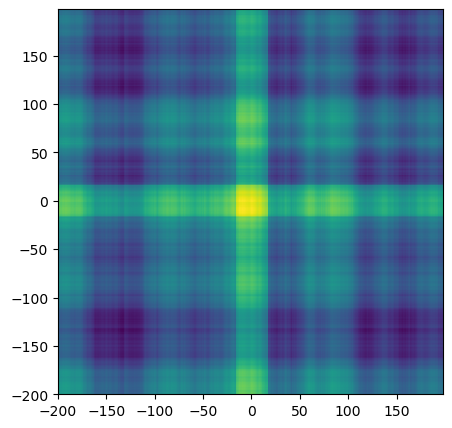

In [ ]:
intensities = []

for ii in range(len(merged_df)):
    # corr_slow = merged_df.cross_corr_slow.values[ii].copy()
    if merged_df.n_coincidients_fast[ii] < 50:
        print(f"Skipping {ii} for {animal} due to low coincidients")
        continue

    corr_slow = merged_df.cross_corr_fast.values[ii].copy()
    corr_fast = merged_df.cross_corr_fast.values[ii].copy()
    if merged_df.peak_delay_slow[ii] < 0:
        corr_slow = np.flip(corr_slow)
        corr_fast = np.flip(corr_fast)

    x_slow = np.arange(-len(corr_slow) // 2, len(corr_slow) // 2)
    x_fast = np.arange(-len(corr_fast) // 2, len(corr_fast) // 2)

    ind_slow = np.where(np.abs(x_slow) < 500)[0]
    ind_fast = np.where(np.abs(x_fast) < 500)[0]
    corr_slow = corr_slow[ind_slow]
    corr_fast = corr_fast[ind_fast]
    x_slow = x_slow[ind_slow]
    x_fast = x_fast[ind_fast]

    val = np.multiply.outer(corr_slow, corr_fast) ** 0.5
    val = val / np.mean(val)  # Normalize the cross product
    intensities.append(val)

val = np.log10(val + 1e-10)  # Log transform to visualize better
plt.figure(figsize=(10, 5))
plt.imshow(val.T, origin="lower", extent=(x_slow[0], x_slow[-1], x_fast[0], x_fast[-1]))
intensities = np.array(intensities)

intensities = np.mean(intensities, axis=0)

Text(0.5, 1.0, 'CrossCorr(Delay 1) * CrossCorr(Delay 2) Winnie early_wtrack')

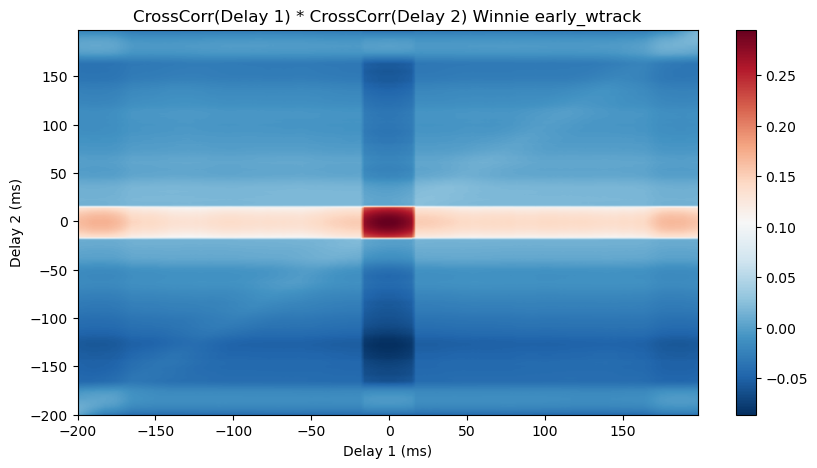

In [ ]:
fig = plt.figure(figsize=(10, 5))
val = intensities.copy()
val = val / np.mean(val, axis=0)  # Normalize the cross product
val = np.log10(val + 1e-10)  # Log transform to visualize better
plt.imshow(
    val,
    origin="lower",
    extent=(x_slow[0], x_slow[-1], x_fast[0], x_fast[-1]),
    cmap="RdBu_r",
    aspect="auto",
)


# val = intensities
# # val = val/ np.sum(val,axis=1)[:, None]  # Normalize the cross product
# plt.imshow(
#     val.T,
#     origin="lower",
#     extent=(x_slow[0], x_slow[-1], x_fast[0], x_fast[-1]),
#     cmap="hot",
#     aspect="auto",
# )

plt.colorbar()
plt.xlabel("Delay 1 (ms)")
plt.ylabel("Delay 2 (ms)")

plt.title(f"CrossCorr(Delay 1) * CrossCorr(Delay 2) {animal} {track}")

Text(0.5, 0.98, 'Totoro: stim on ')

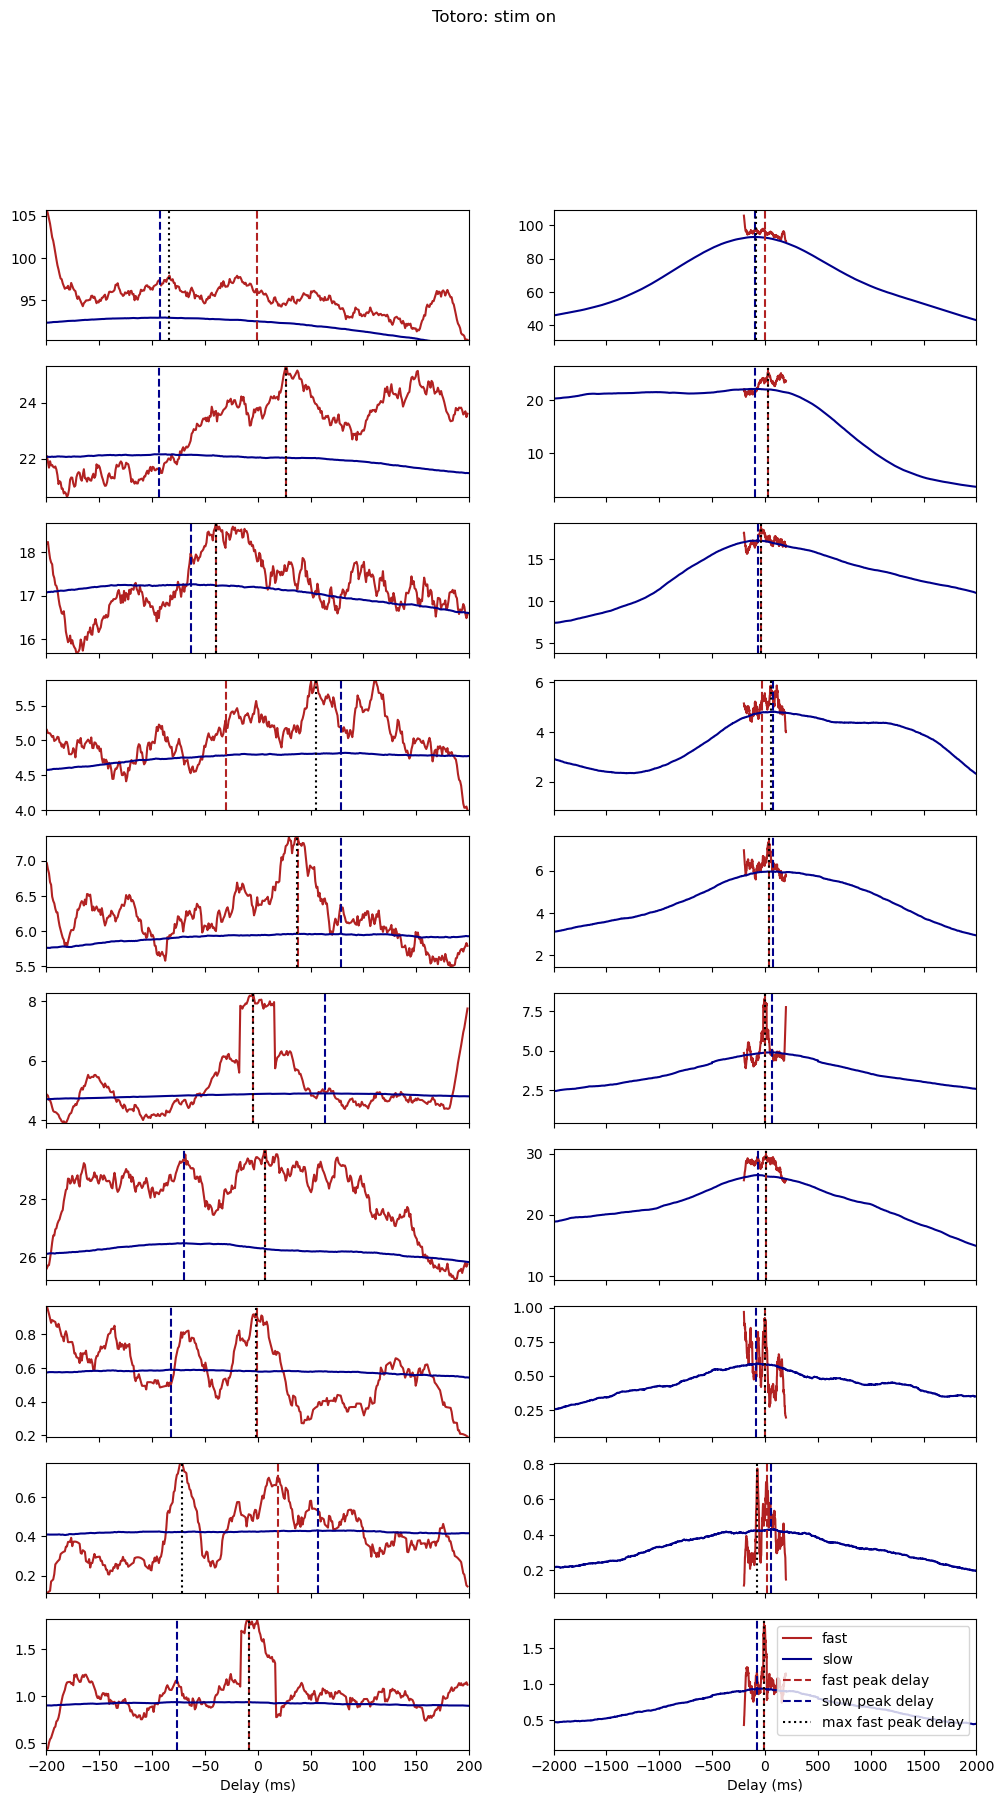

In [276]:
animal = "Totoro"
df = results[animal]["test"]
# df = df[df.peak_delay_slow.abs() >400 ]
# df = df[df.peak_delay_slow.abs() < 1000]
df = df[df.peak_delay_slow.abs() > 50]
df = df[df.peak_delay_slow.abs() < 100]

slow_bins = np.arange(-3000, 2999) + 0.5
fast_bins = np.arange(-200, 199) + 0.5
fast_color = "firebrick"
slow_color = "darkblue"


fig, ax_array = plt.subplots(nrows=10, ncols=2, sharex="col", figsize=(12, 20))


def get_max_fast_peak_delay(row):
    fast_bins = np.arange(-200, 199) + 0.5
    ind_relevant = np.where(np.abs(fast_bins) <= 100)[0]
    # peak_ind = np.argmax(row.cross_corr_fast[ind_relevant])
    # return fast_bins[ind_relevant][peak_ind]
    peak_inds = find_peaks(row.cross_corr_fast[ind_relevant], distance=80)[0]
    peak_values = row.cross_corr_fast[ind_relevant][peak_inds]
    return fast_bins[ind_relevant][peak_inds[np.argmax(peak_values)]]


np.random.seed(1)
for j, pair_i in enumerate(np.random.choice(len(df), 10, replace=False)):
    ax = ax_array[j]
    row = df.iloc[pair_i]
    for i in range(2):
        ax[i].plot(fast_bins, row.cross_corr_fast, label="fast", color=fast_color)
        ax[i].plot(slow_bins, row.cross_corr_slow, label="slow", color=slow_color)
        ax[i].axvline(
            row.peak_delay_fast, ls="--", label="fast peak delay", color=fast_color
        )
        ax[i].axvline(
            row.peak_delay_slow, ls="--", label="slow peak delay", color=slow_color
        )
        ax[i].axvline(
            get_max_fast_peak_delay(row), ls=":", label="max fast peak delay", color="k"
        )
    ax[0].set_ylim(row.cross_corr_fast.min(), row.cross_corr_fast.max())

ax[0].set_xlim(-200, 200)
ax[1].set_xlim(-1000, 1000)
ax[1].set_xlim(-2000, 2000)
ax[0].set_xlabel("Delay (ms)")
ax[1].set_xlabel("Delay (ms)")
# plt.xlim(-500, 500)
plt.legend()
fig.suptitle(f"{animal}: stim on ")
# plt.xlim(-100, 100)

Text(0, 0.5, 'Slow Cross-correlation')

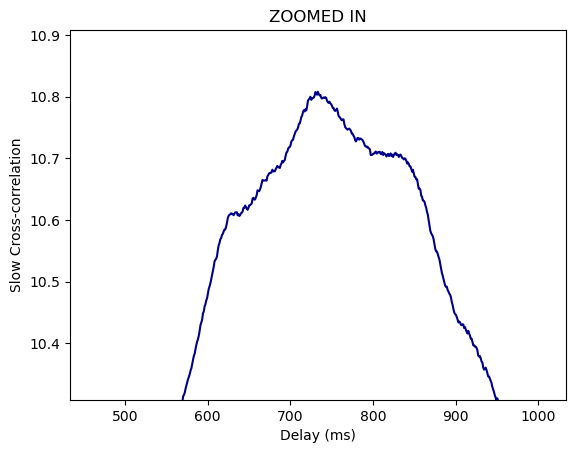

In [133]:
slow_bins = np.arange(-3000, 2999) + 0.5

plt.plot(slow_bins, row.cross_corr_slow, label="slow", color=slow_color)

delay = row.peak_delay_slow
ind = np.digitize(row.peak_delay_slow, slow_bins) - 1
peak_val = row.cross_corr_slow[ind]


plt.xlim(delay - 300, delay + 300)
plt.ylim(peak_val - 0.5, peak_val + 0.1)
plt.title("ZOOMED IN")

plt.xlabel("Delay (ms)")
plt.ylabel("Slow Cross-correlation")

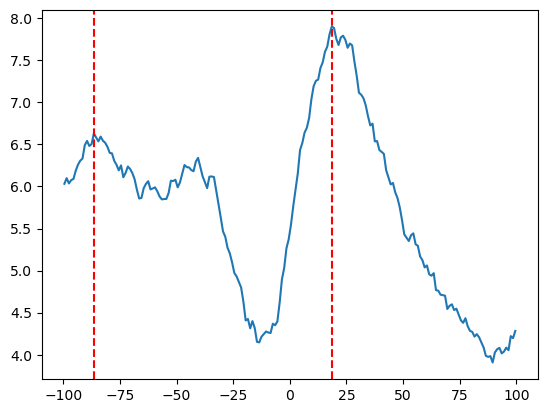

In [56]:
from scipy.signal import find_peaks

ind_relevant = np.where(np.abs(fast_bins) <= 100)[0]
data = row.cross_corr_fast[ind_relevant]
peak_inds = find_peaks(data, distance=80)[0]

fig = plt.figure()
ax = fig.gca()

ax.plot(fast_bins[ind_relevant], data, label="Cross-correlation")
for loc in fast_bins[ind_relevant][peak_inds]:
    ax.axvline(loc, color="red", linestyle="--", label="Peaks")

In [86]:
# np.unique(slow_query.fetch("compression_index_params_name"))
CompressionIndexParams & slow_query

*compression_i filter_speed   min_running_sp pf_bin_size    pf_peak_ratio  delay_range    delay_smoothin min_coincident graph_distance delay_distance smoothing_sigm
+------------+ +------------+ +------------+ +------------+ +------------+ +------------+ +------------+ +------------+ +------------+ +------------+ +------------+
slow_graph_dis 10.0           100            5.0            10.0           1500           250            30             1              2000           nan           
 (Total: 1)

# DEV

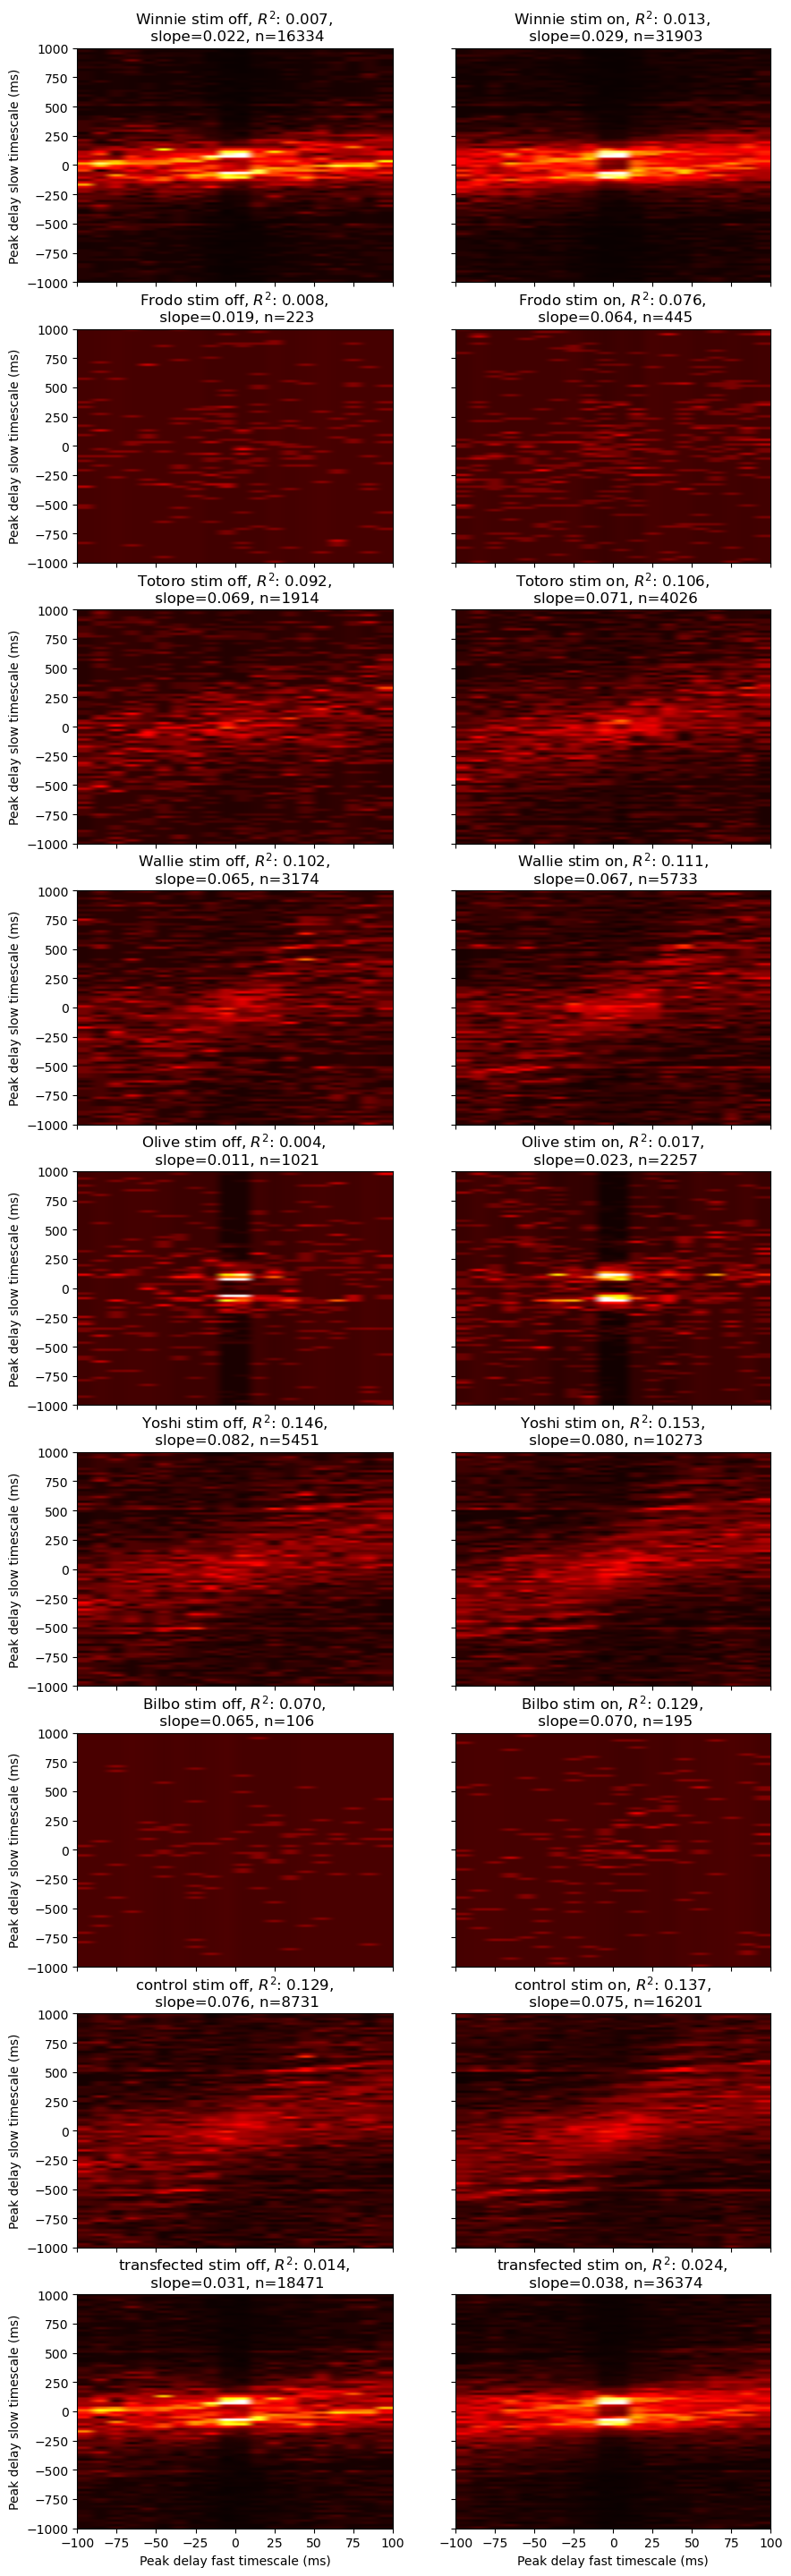

In [270]:
import pandas as pd
import matplotlib.pyplot as plt

upsample = 0
sigma_slow = 5
sigma_fast = 5

log = False
standardize_orders = False
modulo_shift = 0
slow_bin_size = 8
fast_bin_size = 3

slow_bin_size = 20
fast_bin_size = 10

plot_ridge = False
long_timescale_thresh = 200
plot_fit = False

correlation_range = 500

# slow_bin_size = 16
# fast_bin_size = 6
# slow_bin_size = 2
# fast_bin_size = 1

heatmap_results = {}
fast_distribution = {}
slow_distribution = {}
counts = {}
correlations = {}
slopes = {}
long_timescale_counts = {}
fig, ax = plt.subplots(
    ncols=2,
    nrows=len(results),
    sharex=True,
    sharey=True,
    figsize=(10, 4 * len(results)),
)
for a, animal in zip(ax, results.keys()):
    # if animal == "Winnie":
    #     continue
    heatmap_results[animal] = {}
    fast_distribution[animal] = {}
    slow_distribution[animal] = {}
    counts[animal] = {}
    long_timescale_counts[animal] = {}
    correlations[animal] = {}
    slopes[animal] = {}
    merged_control_df = results[animal]["control"]
    merged_test_df = results[animal]["test"]

    lim_x = 1001
    # lim_x = 201
    if standardize_orders:
        bx = np.arange(0, lim_x, slow_bin_size)
    else:
        bx = np.arange(-lim_x, lim_x, slow_bin_size)

    by = np.arange(-100, 100.1, fast_bin_size)

    for a_i, merged_df, cond in zip(
        a, [merged_control_df, merged_test_df], ["stim off", "stim on"]
    ):
        slow_val = merged_df.peak_delay_slow.values.copy()
        # fast_val = merged_df.peak_delay_fast.values.copy()
        fast_val = np.array(
            [get_max_fast_peak_delay(row) for _, row in merged_df.iterrows()]
        )

        raw_slow_val = slow_val.copy()
        raw_fast_val = fast_val.copy()
        counts[animal][cond] = len(merged_df)
        long_timescale_counts[animal][cond] = np.sum(
            np.abs(slow_val > long_timescale_thresh)
        )

        if upsample > 1:
            slow_val = [x for x in slow_val for _ in range(upsample)]
            fast_val = [x for x in fast_val for _ in range(upsample)]
            slow_val = np.array(slow_val) + np.random.normal(
                0, sigma_slow, len(slow_val)
            )
            fast_val = np.array(fast_val) + np.random.normal(
                0, sigma_fast, len(fast_val)
            )

        if standardize_orders:
            ind = np.where(slow_val < 0)[0]
            slow_val[ind] = -slow_val[ind]
            fast_val[ind] = -fast_val[ind]

        if modulo_shift:
            ind = np.where(np.abs(slow_val) < 200)[0]
            steps = np.arange(0, 500, modulo_shift)
            sub_outer = np.subtract.outer(
                slow_val,
                steps,
            )
            min_offset = np.argmin(np.abs(sub_outer), axis=1)
            slow_val = np.array(
                [sub_outer[i, min_offset[i]] for i in range(len(min_offset))]
            )
            slow_val = slow_val[ind]
            fast_val = fast_val[ind]

        dist_slow = np.histogram(slow_val, bins=bx)[0]
        dist_slow = dist_slow / dist_slow.sum()
        slow_distribution[animal][cond] = dist_slow
        dist_fast = np.histogram(fast_val, bins=by)[0]
        dist_fast = dist_fast / dist_fast.sum()
        fast_distribution[animal][cond] = dist_fast

        H, bx, by = np.histogram2d(slow_val, fast_val, bins=(bx, by))

        H = H + 1
        H = H.T
        H = H / H.sum(axis=1)[:, None]
        # H = H / H.sum()

        if log:
            H = np.log10(H + 1e-10)  # Log transform to visualize better
            a_i.imshow(
                H.T,
                origin="lower",
                extent=(bx[0], bx[-1], by[0], by[-1]),
                cmap="hot",
                aspect="auto",
                clim=(-2, -1),
            )
        else:
            a_i.imshow(
                H.T,
                origin="lower",
                extent=(by[0], by[-1], bx[0], bx[-1]),
                cmap="hot",
                aspect="auto",
                clim=(0, 0.1),
            )
        if plot_ridge:
            a_i.plot(bx[1:], by[np.argmax(H, axis=1)], c="cyan")

        ind_corr = np.where(np.abs(raw_slow_val) <= correlation_range)[0]
        corr = np.corrcoef(
            raw_slow_val[ind_corr],
            raw_fast_val[ind_corr],
        )[0, 1]
        correlations[animal][cond] = corr
        slope = linregress(slow_val[ind_corr], fast_val[ind_corr]).slope
        slopes[animal][cond] = slope
        a_i.set_title(
            f"{animal} {cond}, $R^2$: {corr**2:.3f}, \n slope={slope:.3f}, n={counts[animal][cond]}"
        )
        heatmap_results[animal][cond] = H

        if plot_fit:
            # Fit a line to the data
            x_fit = np.linspace(bx[0], bx[-1], 100)
            lin_fit = linregress(slow_val[ind_corr], fast_val[ind_corr])
            slope = lin_fit.slope
            intercept = lin_fit.intercept
            # Generate y values for the fit line
            y_fit = slope * x_fit + intercept
            a_i.plot(x_fit, y_fit, color="cyan", linestyle="--", linewidth=1)

        # break
# plt.colorbar(label='Counts')


lim = 1000
if modulo_shift:
    plt.ylim(-modulo_shift // 2, modulo_shift // 2)
elif standardize_orders:
    plt.ylim(0, lim)
else:
    plt.ylim(-lim, lim)
for a in ax[-1, :]:
    # a.set_ylim(-80, 80)
    a.set_xlim(-100, 100)
    xlabel = "Peak delay fast timescale (ms)"
    if modulo_shift:
        xlabel = f"Peak delay fast timescale (ms) modulo {modulo_shift}, shifted"
    a.set_xlabel(xlabel)
for a in ax[:, 0]:
    a.set_ylabel("Peak delay slow timescale (ms)")
    # a.set_xticks(np.arange(-lim, lim + 1, 100))
    # a.set_yticks(np.arange(-80, 81, 20))
# np.corrcoef(merged_control_df.peak_delay_slow, merged_control_df.peak_delay_fast)

# New Idea

Text(0.5, 1.0, 'Yoshi wtrack stim on')

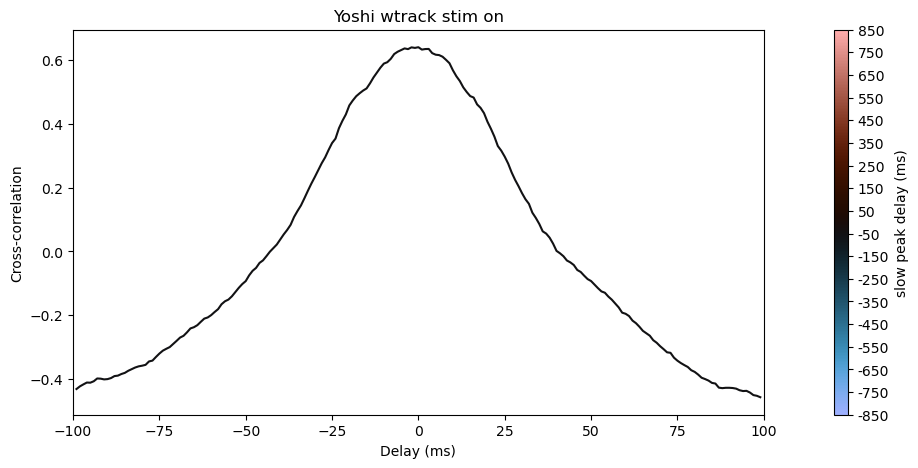

In [ ]:
import matplotlib as mpl

animal = "transfected"

animal = "Yoshi"
cond = "test"

df = results[animal][cond]

delay_bins = np.arange(-550, 551, 100)

delay_bins = np.arange(-850, 851, 100)

fig, ax = plt.subplots(figsize=(10, 5), ncols=2, width_ratios=[1, 0.02])
delta_t = np.arange(-200, 200, 1)  # Time lags for cross-correlation
ind = np.where(np.abs(delta_t) < 100)[0]  # Relevant indices for cross-correlation
peaks = []
peak_val = []
cmap = plt.cm.berlin
for i in range(delay_bins.size - 1):
    if not i == delay_bins.size // 2 - 1:
        continue
    color = cmap(i / (delay_bins.size - 1))
    rng = (delay_bins[i], delay_bins[i + 1])
    df_rng = df[
        np.logical_and(df.peak_delay_slow > rng[0], df.peak_delay_slow < rng[1])
    ]
    data = np.array([x for x in df_rng.cross_corr_fast.values])[:, ind]
    data = data - np.mean(data, axis=1)[:, None]
    ax[0].plot(
        delta_t[ind], np.mean(data, axis=0), label="Mean cross-correlation", color=color
    )
    peaks.append(delta_t[ind][np.argmax(np.mean(data, axis=0))])
    peak_val.append(np.max(np.mean(data, axis=0)))
    # ax[0].fill_between(
    #     delta_t[ind],
    #     np.percentile(data, 25, axis=0),
    #     np.percentile(data, 75, axis=0),
    #     color=color,
    #     alpha=0.2,
    # )

# ax[0].plot(peaks, peak_val, color="k", label="Peak delay")
# ax[0].scatter(peaks, peak_val, c=delay_bins[:-1], cmap=plt.cm.viridis, edgecolor='k', s=100,zorder=100)


# Create a ScalarMappable for the colorbar using the same colormap and normalization as used for 'color'
norm = mpl.colors.Normalize(vmin=delay_bins[0], vmax=delay_bins[-1])
sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # Only needed for older matplotlib

cbar = plt.colorbar(sm, label="slow peak delay (ms)", cax=ax[1])
cbar.set_ticks(delay_bins)
cbar.set_ticklabels(
    [f"{int(b)}" for b in delay_bins],
)

ax[0].set_xlim(-100, 100)
ax[0].set_xlabel("Delay (ms)")
ax[0].set_ylabel("Cross-correlation")
# plt.colorbar(label="slow peak delay (ms)")
# data = data / np.max(np.abs(data), axis=1)[:, None]  # Normalize each row
ax[0].set_title(f"{animal} wtrack {'stim on' if cond == 'test' else 'stim off'}")

In [80]:
peaks

[-93, -45, -44, -32, -20, -17, -8, -3, 6, 3, 9, 13, 36, 71, 46, 37]

In [81]:
peak_val

[0.08523605355627985,
 0.14710131003864677,
 0.16063488286319105,
 0.18625978085197178,
 0.24089780061514923,
 0.2300654122281354,
 0.26065299313176266,
 0.3394087131278255,
 0.2553077344806139,
 0.3022201677222826,
 0.2158890785863549,
 0.1592811052139432,
 0.18743609175362222,
 0.07988359928839545,
 0.11884163083200382,
 0.09560339798440902]